### Task 8HD : Data Cleansing and Text Analysis Challenge
### Truong Khang Thinh Nguyen - 223446545
### Email : s223446545@gmail.com
### SIT220 - Undergraduate

#### This report endeavors to delve deeper into the History Stack Exchange site, aiming to extract valuable patterns, trends, and insights about its users through the utilization of regular expressions. While traditional exploratory data analysis (EDA) provides an overview of the data, the use of regular expressions enables us to unexplored details and relationships within the text data. For instance, by employing regular expressions, we can extract specific information such as locations mentioned in the posts, allowing us to visualize user activity geographically through mapping. Beyond merely skimming the surface of the data, this approach empowers us to uncover hidden gems of knowledge and gain a more comprehensive understanding of user interactions and interests on the History Stack Exchange platform.

#### Moreover, this report goes beyond basic exploratory analysis by delving into the relationship between sentiment expressed in comments and various factors such as post length, sentiment of the post title and body, and other contextual attributes. By leveraging regular expressions to extract sentiment-related information from the text data, we can discern patterns and correlations that may otherwise remain unnoticed. For example, we may discover that longer posts tend to elicit more diverse sentiments in the comments, or that the sentiment expressed in the post title strongly influences the sentiment of subsequent comments. This deeper analysis not only enriches our understanding of user behavior and engagement on the platform but also provides valuable insights for content creators, moderators, and platform administrators to enhance user experience and foster community engagement.

In [2]:
# Packages for csv and XML files manipulation
import xml.etree.ElementTree as ET
import csv

# Data Manipulation packages
import pandas as pd
import numpy as np
import re

# Packages for plotting
import folium
from folium.plugins import MarkerCluster
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Packages for building a regresison model
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

# Import neccessary packages to analyse the sentiments and the polarity scores of the text
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [803]:
# Create a function to parse the XML file and then create a corresponded csv file
def xml_to_csv(input_file, output_file):
    # Parse the XML file
    tree = ET.parse(input_file)
    root = tree.getroot()

    # Open the CSV file for writing
    with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
        # Create a CSV writer object
        csvwriter = csv.writer(csvfile)
        
        # Extract all column names from the first element (assuming all elements have the same structure)
        first_element = root[0]
        column_names = first_element.attrib.keys()
        csvwriter.writerow(column_names)  # Write the header
        
        # Write data rows
        for element in root:
            row = [element.attrib.get(col, '') for col in column_names]
            csvwriter.writerow(row)

# Use the defined function to pass the XML file and the wanted csv file name
xml_to_csv('Badges.xml', 'Badges.csv')
xml_to_csv('Comments.xml', 'Comments.csv')
xml_to_csv('PostHistory.xml', 'PostHistory.csv')
xml_to_csv('PostLinks.xml', 'PostLinks.csv')
xml_to_csv('Posts.xml', 'Posts.csv')
xml_to_csv('Tags.xml', 'Tags.csv')
xml_to_csv('Users.xml', 'Users.csv')
xml_to_csv('Votes.xml', 'Votes.csv')


In [804]:
# Load datasets from the created csv files
Badges = pd.read_csv("Badges.csv")
Cmt = pd.read_csv("Comments.csv")
PostHistory = pd.read_csv("PostHistory.csv")
PostLink = pd.read_csv("PostLinks.csv")
Post = pd.read_csv("Posts.csv")
Tags = pd.read_csv("Tags.csv")
Users = pd.read_csv("Users.csv")
Vote = pd.read_csv("Votes.csv")

##### To kick off our analysis, we first need to perform an Exploratory Data Analysis (EDA) to get a broad understanding of the dataset's characteristics.

##### Initially, we should generate copies of each dataset we've just created. This way, any modifications made to the duplicates won't impact the original datasets.

In [805]:
badges_df = Badges
cmt_df = Cmt
posthis_df = PostHistory
post_df = Post
tag_df = Tags
user_df = Users
vote_df = Vote

##### As we are currently in Australia so I'll compile historical events by summarizing the top 10 posts with the highest views from Stack Exchange data.


In [806]:
# Function to remove tags from the text
def remove_html_tags(text):
    # Define the regular expression pattern to match HTML tags
    html_pattern = re.compile(r'<.*?>')
    
    # Use re.sub() to replace HTML tags with an empty string
    clean_text = re.sub(html_pattern, '', text)
    
    return clean_text


In [807]:
# Function to extract the capitalized words from titles ==> Get Keywords
def extract_capitalized_words(title):
    # Use regex to find capitalized words
    capitalized_words = re.findall(r'\b[A-Z][a-z]*\b', title)
    return ' '.join(capitalized_words)

Initially, we'll eliminate rows that don't have any tags.

In [808]:
post_df.dropna(subset = "Tags",inplace = True)

Then filter out rows that just have the "australian" 

In [809]:
# Filter rows where the "tags" column contains "Australia"
aus_df = post_df[post_df["Tags"].str.contains(r"\baustralia\b")]
aus_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, 65 to 43635
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                59 non-null     int64  
 1   PostTypeId        59 non-null     int64  
 2   CreationDate      59 non-null     object 
 3   Score             59 non-null     int64  
 4   ViewCount         59 non-null     float64
 5   Body              59 non-null     object 
 6   OwnerUserId       51 non-null     float64
 7   LastEditorUserId  41 non-null     float64
 8   LastEditDate      43 non-null     object 
 9   LastActivityDate  59 non-null     object 
 10  Title             59 non-null     object 
 11  Tags              59 non-null     object 
 12  AnswerCount       59 non-null     float64
 13  CommentCount      59 non-null     int64  
 14  ContentLicense    59 non-null     object 
dtypes: float64(4), int64(4), object(7)
memory usage: 7.4+ KB


In [810]:
# Let's have a look at our dataframe that just has Aus tag
aus_df

,Id,PostTypeId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorUserId,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,ContentLicense
65,73,1,2011-10-11T22:18:54.920,9,633.0,<p>Why were many Aboriginal names kept for tow...,73.0,16.0,2011-10-13T20:52:02.737,2011-12-06T01:29:53.427,Australian towns / cities with Aboriginal names,|australia|aboriginals|,1.0,0,CC BY-SA 3.0
76,85,1,2011-10-11T23:24:12.227,14,903.0,"<p>In my hometown (Eastwood NSW, Australia) we...",73.0,85.0,2012-11-20T16:18:53.453,2023-08-24T20:53:24.863,Was the Granny Smith Apple the first green ski...,|australia|food|,2.0,11,CC BY-SA 3.0
252,273,1,2011-10-13T21:55:31.070,4,2548.0,"<p>This wikipedia article on <a href=""http://e...",73.0,16.0,2011-10-13T22:24:54.863,2018-07-26T05:10:33.223,Why did Arthur Philip decide to move to Port J...,|australia|18th-century|settlement|,1.0,1,CC BY-SA 3.0
257,279,1,2011-10-13T22:29:48.187,13,491.0,<p>There are two that I am aware of:</p>\n\n<u...,73.0,16.0,2011-10-14T16:45:39.860,2017-12-04T22:56:17.030,How many recorded incidents are there of attac...,|war|australia|defense|,4.0,2,CC BY-SA 3.0
304,328,1,2011-10-14T21:42:48.133,5,1063.0,"<p>Frank Welsh's mammoth history of Australia,...",106.0,106.0,2013-07-05T22:01:55.030,2019-11-20T21:05:12.523,How was Australia able to start to demobilize ...,|world-war-two|military|australia|,2.0,1,CC BY-SA 3.0
1011,1120,1,2012-01-05T21:32:19.320,2,629.0,<p>A simple question that is not so simple to ...,NaN,NaN,NaN,2012-02-02T20:00:54.850,How did the early settlers of Australia settle...,|australia|aboriginals|,1.0,3,CC BY-SA 3.0
1458,1652,1,2012-03-26T00:00:18.023,5,154.0,"<p>The <a href=""http://en.wikipedia.org/wiki/P...",49.0,102.0,2012-03-26T13:18:53.657,2012-05-14T03:49:00.580,What caused the decline in support for the Pro...,|government|australia|election|,1.0,0,CC BY-SA 3.0
1575,1785,1,2012-04-17T17:14:53.843,22,109061.0,<p>I asked this question in various places on ...,NaN,-1.0,2015-07-06T09:35:26.337,2018-05-28T10:09:10.750,"Why did Canada, Australia and New Zealand sepa...",|british-empire|united-kingdom|ireland|austral...,9.0,6,CC BY-SA 3.0
1844,2073,1,2012-05-16T10:44:12.327,5,360.0,<p>Anyone who listens to Question Time in Aust...,49.0,NaN,NaN,2012-08-30T02:22:41.437,Why did Dorothy Dixers become prevalent in que...,|australia|political-history|,1.0,4,CC BY-SA 3.0
2305,2575,1,2012-07-12T17:19:08.040,26,32613.0,<p>My Australian friend says yes. I'm not so s...,282.0,3810.0,2014-03-15T11:38:12.450,2017-02-09T15:05:49.873,Can the Queen of England fire the prime minist...,|australia|monarchy|,4.0,3,CC BY-SA 3.0


To effectively identify historical events within each post, we'll analyze both the title and the body. Currently, the bodies of each post are in HTML format, so we'll need to reformat them for better readability.

In [811]:
aus_df["Clean Body"] = aus_df["Body"].apply(remove_html_tags)
aus_df[["Clean Body"]].head()

C:\Users\thinh\AppData\Local\Temp\ipykernel_31980\3475504514.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus_df["Clean Body"] = aus_df["Body"].apply(remove_html_tags)


,Clean Body
65,Why were many Aboriginal names kept for town a...
76,"In my hometown (Eastwood NSW, Australia) we an..."
252,This wikipedia article on Botany Bay suggests ...
257,There are two that I am aware of:\n\n\nJapanes...
304,"Frank Welsh's mammoth history of Australia, Gr..."


Next, we'll extract keywords from the titles to identify significant events. Typically, keywords related to major events will be capitalized.

In [812]:
aus_df["Key Words"] = aus_df["Title"].apply(extract_capitalized_words)
aus_df[["Title","Key Words"]].head()

C:\Users\thinh\AppData\Local\Temp\ipykernel_31980\227904103.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus_df["Key Words"] = aus_df["Title"].apply(extract_capitalized_words)


,Title,Key Words
65,Australian towns / cities with Aboriginal names,Australian Aboriginal
76,Was the Granny Smith Apple the first green ski...,Was Granny Smith Apple
252,Why did Arthur Philip decide to move to Port J...,Why Arthur Philip Port Jackson Botany Bay
257,How many recorded incidents are there of attac...,How Australian
304,How was Australia able to start to demobilize ...,How Australia


Following that, we'll select the top 10 posts with the highest views which may contain significant events in Australian history.

In [813]:
aus_df.sort_values(by = "ViewCount", ascending = False,inplace = True)
top10_aus = aus_df.head(10)
top10_aus

C:\Users\thinh\AppData\Local\Temp\ipykernel_31980\3544104814.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus_df.sort_values(by = "ViewCount", ascending = False,inplace = True)


,Id,PostTypeId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorUserId,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,ContentLicense,Clean Body,Key Words
1575,1785,1,2012-04-17T17:14:53.843,22,109061.0,<p>I asked this question in various places on ...,NaN,-1.0,2015-07-06T09:35:26.337,2018-05-28T10:09:10.750,"Why did Canada, Australia and New Zealand sepa...",|british-empire|united-kingdom|ireland|austral...,9.0,6,CC BY-SA 3.0,I asked this question in various places on the...,Why Canada Australia New Zealand
10932,19256,1,2015-02-07T11:43:17.103,25,35350.0,<p>The aborigines are believed to have migrate...,8451.0,8451.0,2016-03-12T14:37:21.250,2018-03-28T00:22:32.030,Did the aborigines of Australia and the Maoris...,|australia|aboriginals|new-zealand|,4.0,4,CC BY-SA 3.0,The aborigines are believed to have migrated f...,Did Australia Maoris New Zealand Europeans
2305,2575,1,2012-07-12T17:19:08.040,26,32613.0,<p>My Australian friend says yes. I'm not so s...,282.0,3810.0,2014-03-15T11:38:12.450,2017-02-09T15:05:49.873,Can the Queen of England fire the prime minist...,|australia|monarchy|,4.0,3,CC BY-SA 3.0,My Australian friend says yes. I'm not so sure...,Can Queen England Australia
15714,28456,1,2016-04-25T10:53:38.920,45,25830.0,<p>Leaving aside the naval battles of the Paci...,10028.0,4390.0,2016-04-26T21:25:31.293,2024-02-03T05:01:41.707,Why was the Japanese Army's fatalities inflict...,|united-states|world-war-two|japan|australia|,7.0,12,CC BY-SA 3.0,Leaving aside the naval battles of the Pacific...,Why Japanese Army Pacific
33259,54976,1,2019-10-11T14:23:10.420,46,15301.0,"<p>From what I've gathered at a glance, Aborig...",40601.0,40601.0,2019-10-14T06:39:49.547,2024-03-22T11:08:29.800,Why didn't Aboriginal Australians invent agric...,|australia|,8.0,6,CC BY-SA 4.0,"From what I've gathered at a glance, Aborigine...",Why Aboriginal Australians
3000,4381,1,2012-10-22T11:40:59.687,25,11028.0,<p>Australia hosted aboriginal populations sin...,1436.0,1110.0,2012-11-03T19:02:36.883,2021-01-28T09:14:11.107,Why did Austronesian/Polynesian people not col...,|colonization|australia|south-east-asia|,8.0,11,CC BY-SA 3.0,Australia hosted aboriginal populations since ...,Why Austronesian Polynesian Australia
19672,35586,1,2017-02-18T16:47:09.013,11,7004.0,<p>Is there any evidence of ancient Chinese ex...,23474.0,56412.0,2022-10-06T16:37:28.960,2023-11-24T00:21:38.513,Is there evidence of ancient Chinese explorati...,|australia|exploration|,1.0,3,CC BY-SA 4.0,Is there any evidence of ancient Chinese explo...,Is Chinese Australia
7415,11784,1,2014-02-22T05:22:52.353,5,5402.0,<p>The common explanation for the usage of Aus...,3682.0,3682.0,2014-03-06T14:55:04.387,2014-03-06T15:09:47.163,"America vs. Australia as a ""Penal Colony""",|united-states|australia|colony|,1.0,1,CC BY-SA 3.0,The common explanation for the usage of Austra...,America Australia Penal Colony
7577,11981,1,2014-03-08T03:44:39.397,0,3795.0,"<p>In Australia's History, the Europeans tried...",NaN,NaN,NaN,2014-03-09T22:05:16.410,Did any other countries try to breed a race ou...,|australia|aboriginals|,1.0,13,CC BY-SA 3.0,"In Australia's History, the Europeans tried to...",Did Australia
9807,16773,1,2014-10-23T22:42:44.587,15,3716.0,<p>The gold rush in Australia saw many <a href...,49.0,NaN,NaN,2018-11-20T04:39:13.560,Which fruits and vegetables did Chinese migran...,|food|agriculture|australia|,1.0,4,CC BY-SA 3.0,The gold rush in Australia saw many Chinese mi...,Which Chinese Australia


In [814]:
# Print out the rows that contain the title, body, and keyword of that post
for row_idx, (title, body, keyword) in enumerate(zip(top10_aus["Title"], top10_aus["Clean Body"], top10_aus["Key Words"]), start=1):
    print(f"ROW {row_idx} :")
    print(f"Title: {title}")
    print(body)
    print(f"****KEYWORD: {keyword}")
    print("==" * 30)
    print()

ROW 1 :
Title: Why did Canada, Australia and New Zealand separate from the UK?
I asked this question in various places on the Web. I haven't received a clear answer.

The USA separated from the UK because the people felt that they were not British, and they weren't.

Weren't Canadians/Australians/New Zealanders also descended from the British?

Or was it that UK was unable to administer them for financial reasons? I will not accept this as an answer. In this case why was the UK able to hold on to to Scotland, England, Northern Ireland and Wales?

Why are Canada/Australia/New Zealand not administered from the UK?

****KEYWORD: Why Canada Australia New Zealand

ROW 2 :
Title: Did the aborigines of Australia and the Maoris in New Zealand know about each other's existence, before the Europeans came?
The aborigines are believed to have migrated from India in prehistoric times. The Maoris are thought to have arrived from Polynesia and elsewhere in eastern Asia. They travelled by canoe.

It's

Now that we've identified the major historical events based on the posts with the highest view counts, let's create a map and mark the locations to aid in our interpretation.

Separation of Australia from the United Kingdom in Westminster.

In [4]:
# Define additional information for Westminster, London popup
westminster_popup_html = """
<h4>Westminster - Separation of Australia from the United Kingdom in Westminster</h4>

<section>
    <h5>Introduction</h5>
    <p>The separation of Australia from the United Kingdom in Westminster refers to the process through which Australia gained legislative independence from the UK Parliament.</p>
    <p>This process culminated in the passage of the Statute of Westminster Adoption Act 1942 by the Australian Parliament.</p>
    <p>The act effectively recognized Australia's legislative autonomy, allowing it to pass laws without requiring approval from the British Parliament.</p>
</section>

<section>
    <h5>Background</h5>
    <p>Before this separation, Australia, along with other British Dominions, operated under the legal framework of British parliamentary sovereignty.</p>
    <p>However, as Australia grew and developed as a nation, there was increasing sentiment for greater autonomy and self-governance.</p>
    <p>The Statute of Westminster 1931 laid the groundwork for this process by granting legislative independence to the self-governing Dominions of the British Empire, including Australia.</p>
    <p>However, Australia initially hesitated to adopt the statute due to concerns about its potential impact on the federation and constitutional arrangements.</p>
</section>

<section>
    <h5>Legislative Independence</h5>
    <p>It wasn't until the outbreak of World War II and the fall of Singapore in 1942 that the Australian government felt the urgency to assert its legislative independence.</p>
    <p>In response to these events, the Australian Parliament passed the Statute of Westminster Adoption Act 1942, formally adopting the Statute of Westminster and severing legislative ties with the UK Parliament.</p>
    <p>This act marked a significant milestone in Australia's journey towards full sovereignty and independence.</p>
    <p>It represented a symbolic and practical step towards asserting Australia's status as a fully independent nation within the Commonwealth.</p>
</section>
"""


Torres Strait Islands - interactions between the Aboriginal peoples of Australia and the Māori of New Zealand.

In [5]:
torrens_strait_popup_html = """
<h4>Torres Strait Islands</h4>
<section>
    <h5>Introduction</h5>
    <p>The Torres Strait Islands are a group of at least 274 small islands in the Torres Strait waterway between Australia and Papua New Guinea.</p>
    <p>The islands are home to the Indigenous Torres Strait Islander people and have a rich cultural heritage.</p>
</section>

<section>
    <h5>Interactions with Aboriginal Australians and the Māori</h5>
    <p>While there isn't extensive direct evidence of regular contact between Aboriginal Australians and the Māori prior to European arrival, it's theorized that some limited interaction may have occurred through the Torres Strait Islands. Both Aboriginal Australians and the Māori are thought to have had maritime capabilities, with the Māori famously known for their impressive voyaging canoes.</p>
    <p>The Torres Strait Islands were inhabited by Indigenous Torres Strait Islander peoples who had established trade networks and cultural connections with neighboring regions, including Papua New Guinea and other parts of the Pacific. It's possible that these islanders served as intermediaries or facilitators of contact between the Aboriginal peoples of Australia and the Māori of New Zealand.</p>
    <p>However, the exact nature and extent of these interactions remain subjects of ongoing research and debate among historians, anthropologists, and archaeologists. While evidence suggests some level of contact and exchange, further studies are needed to fully understand the dynamics of pre-European contact between these Indigenous groups through the Torres Strait Islands.</p>
</section>
"""


Canberra, the capital of Australia, is where decisions are made by the Prime Minister.

In [6]:
# Define the popup HTML content for Canberra
canberra_popup_html = """
<h4>Canberra, Australia</h4>
<section>
    <h5>Constitutional Monarchy</h5>
    <p>Australia operates as a constitutional monarchy with a parliamentary system of government. The Queen of England is the head of state, but her powers are largely ceremonial and symbolic.</p>
</section>
<section>
    <h5>Appointment of Prime Minister</h5>
    <p>The Prime Minister of Australia is appointed by the Governor-General, who is the Queen's representative in Australia. However, this appointment is based on the political realities of the Australian Parliament, specifically the party or coalition of parties that commands the majority in the House of Representatives.</p>
</section>
<section>
    <h5>Removal of Prime Minister</h5>
    <p>In practice, the Prime Minister serves at the pleasure of the Australian Parliament and can be removed through political processes such as a vote of no confidence or a leadership spill within the Prime Minister's party.</p>
</section>
"""

Guadalcanal holds importance for Australia due to its role as a significant battleground during World War II, where both Allied and Japanese forces were engaged in a major campaign.

In [7]:
japan_popup_html = """
<h4>Guadalcanal</h4>
<section>
    <h5>Background</h5>
    <p>Guadalcanal, located in the Solomon Islands, holds historical significance for Australia as it was the site of a major campaign during World War II involving Allied and Japanese forces.</p>
</section>
<section>
    <h5>Battle</h5>
    <p>The battle for Guadalcanal, which raged from August 1942 to February 1943, saw heavy casualties for both sides. The Japanese suffered significant losses while attempting to defend the island against Allied invasion.</p>
</section>
<section>
    <h5>Significance</h5>
    <p>The campaign for Guadalcanal marked a pivotal moment in the Pacific theater of World War II. It represented the first major offensive launched by Allied forces against Japanese-held territory.</p>
    <p>The eventual Allied victory at Guadalcanal provided Australia with a strategic foothold in the Solomon Islands, strengthening its position in the region and contributing to the overall Allied effort against Japanese expansion in the Pacific.</p>
</section>
"""

Uluru, also known as Ayers Rock, which is a culturally significant landmark in central Australia and holds significance to the Aboriginal people. This location serves as a symbolic representation of Aboriginal culture and heritage.

In [8]:
uluru_popup_html = """
<h4>Uluru - Factors Influencing the Absence of Agriculture Among Aboriginal Australians</h4>
<section>
    <h5>Background</h5>
    <p>Despite their lengthy history of approximately 50,000 years on the continent, Aboriginal Australians did not develop agriculture to the extent seen in other parts of the world.</p>
    <p>While some argue that the temperate and subtropical climates of Australia could have supported agricultural practices, the development of advanced technology and agricultural systems among Aboriginal civilizations remained limited compared to counterparts in the Old World.</p>
</section>
<section>
    <h5>Factors</h5>
    <p>Factors such as isolation, limited resources, and cultural practices may have hindered the development and adoption of agricultural techniques among Aboriginal Australians.</p>
    <p>While geographical factors may have played a role, other challenges likely contributed to the absence of agricultural practices.</p>
</section>
<section>
    <h5>Conclusion</h5>
    <p>The absence of agriculture among Aboriginal Australians likely resulted from a combination of geographical, cultural, and historical factors that influenced their societies' development and technological advancements.</p>
</section>
"""

Absence of Austronesian/Polynesian Colonization.

In [9]:
polynesian_popup_html = """
<h4>Torres Strait Islands - Factors Influencing the Absence of Austronesian/Polynesian Colonization of Australia</h4>
<section>
    <p>Despite the presence of Aboriginal populations in Australia since prehistory, neighboring regions such as Indonesia, Polynesia, and New Guinea were home to technologically advanced civilizations. However, the Austronesian and Polynesian peoples did not colonize Australia, raising questions about the reasons behind this absence of colonization and whether there is evidence of interaction or invasion.</p>
</section>
<section>
    <h5> Geographic Barriers</h5>
    <p>The vast expanses of open sea, such as the Torres Strait, separating Australia from neighboring regions could have posed significant challenges to maritime navigation and exploration.</p>
</section>
<section>
    <h5> Cultural Priorities</h5>
    <p>Austronesian and Polynesian societies may have had different cultural priorities or objectives that did not include expansion into Australia. These societies might have focused on other areas for settlement, resource exploitation, or cultural development.</p>
</section>
<section>
    <h5> Adaptation to Local Environments</h5>
    <p>The ecosystems and environments of Australia differ significantly from those of neighboring regions. Austronesian and Polynesian peoples may have been better adapted to the maritime and island environments of their homelands, making the Australian continent less attractive for colonization.</p>
</section>
<section>
    <h5> Resource Availability</h5>
    <p>Australia's arid and harsh interior may have presented challenges in terms of resource availability for potential colonizers. The lack of reliable freshwater sources and fertile land suitable for agriculture could have deterred Austronesian and Polynesian peoples from establishing permanent settlements in Australia.</p>
</section>
<section>
    <h5> Limited Evidence of Interaction</h5>
    <p>While there is some evidence of contact and interaction between Aboriginal Australians and Austronesian/Polynesian peoples, such as the presence of traded goods and linguistic connections, there is limited evidence of large-scale colonization or invasion.</p>
</section>
<p>Overall, the absence of Austronesian/Polynesian colonization of Australia likely resulted from a combination of geographical, cultural, and environmental factors that influenced the priorities and capabilities of these societies.</p>
"""


Sydney - Ancient Chinese Exploration of Australia.

In [10]:
sydney_popup_html = """
<h4>Sydney - Evidence of Ancient Chinese Exploration of Australia</h4>

<section>
    <h5>Introduction</h5>
    <p>Exploring the possibility of ancient Chinese exploration of Australia before extensive contact with Europeans during the Middle Ages raises intriguing questions about maritime history and cross-cultural interactions.</p>
</section>

<section>
    <h5>Background</h5>
    <p>While concrete evidence of direct Chinese exploration remains elusive, several theories and pieces of evidence suggest the potential for early Chinese contact with the Australian continent.</p>
</section>

<section>
    <h5>Evidence</h5>
    <p>One notable piece of evidence is the presence of ancient Chinese maps, such as the Kangnido and Zheng He's maps, which depict lands far beyond China's borders, including regions that could correspond to parts of Australia.</p>
    <p>Additionally, archaeological findings, such as Chinese artifacts discovered along the northern coast of Australia, fuel speculation about possible contact between Chinese voyagers and Indigenous Australian populations.</p>
    <p>Historical records and accounts, such as those from Chinese voyages led by Zheng He in the early 15th century, offer further insights into the potential for Chinese maritime expeditions to have reached distant shores, including parts of Australia.</p>
</section>

<section>
    <h5>Conclusion</h5>
    <p>Overall, while conclusive evidence of ancient Chinese exploration of Australia remains elusive, various theories, artifacts, maps, and historical accounts suggest the intriguing possibility of early cross-cultural encounters between Chinese sailors and Indigenous Australians.</p>
    <p>Further archaeological research, interdisciplinary studies, and exploration of historical sources may shed more light on this fascinating topic.</p>
</section>
"""

America vs. Australia as a "Penal Colony".

In [11]:
america_vs_australia_html = """
<h4>Sydney - America vs. Australia as a "Penal Colony"</h4>

<section>
    <h5>Introduction</h5>
    <p>The common explanation for the usage of Australia as a penal colony is that the American Revolution made the usage of America as one no longer tenable.</p>
</section>

<section>
    <h5>Background</h5>
    <p>Before the American Revolution, Britain sent many convicts to the American colonies, often as indentured servants. These indentured servants were sold to work for a specified number of years.</p>
    <p>After the American colonies gained independence, Britain had to find an alternative location for its convicts, leading to the establishment of Australia as a penal colony.</p>
</section>

<section>
    <h5>Differences in Methods</h5>
    <p>The American model involved selling convicts as indentured servants who were eventually integrated into the population. In contrast, the Australian model involved the establishment of penal colonies where convicts were isolated and worked on public projects or in designated settlements.</p>
</section>

<section>
    <h5>Development of the Australian Model</h5>
    <p>The Australian convict transportation model involved strict supervision, infrastructure establishment, and the gradual transition of convicts into free settlers once their sentences were served. This system significantly influenced the development of Australian society.</p>
</section>
"""

Did Any Other Countries Attempt to Breed Out a Race Like in Australia?

In [12]:
breeding_out_popout_html = """
<h4>Canberra - Did Any Other Countries Attempt to Breed Out a Race Like in Australia?</h4>

<section>
    <p>In Australia's history, the policy of "breeding out the colour" involved pairing Aboriginal women with white men. This practice was part of a broader effort to assimilate Aboriginal people and erase their cultural and racial identity. The policy was driven by several beliefs:</p>
</section>

<section>
    <h5>Beliefs Behind the Policy</h5>
    <ul>
        <li>Aboriginals were a dying race: Europeans believed that Aboriginal people would eventually die out and saw interbreeding as a way to manage this perceived inevitability.</li>
        <li>Australia was a 'white man's' country: The policy was part of a broader effort to maintain Australia as a predominantly white nation.</li>
        <li>Erasing the black colour: By encouraging mixed-race marriages and subsequent generations, the aim was to gradually eliminate the physical characteristics associated with Aboriginal people.</li>
    </ul>
    <p>This policy was implemented during the era known as the Stolen Generation, roughly from 1909 to 1969. Many Aboriginal children were forcibly removed from their families and placed in institutions or with white families to be assimilated into white society.</p>
</section>

<section>
    <h5>Comparison with Other Countries</h5>
    <p>The concept of "breeding out" a race has been seen in other contexts as well, though the specifics and motivations may differ:</p>
    <ul>
        <li><strong>United States:</strong> Various assimilation policies aimed at Native American populations, including forced removals and boarding schools.</li>
        <li><strong>Canada:</strong> Similar to the US, with residential schools and policies to assimilate Indigenous populations.</li>
        <li><strong>Nazi Germany:</strong> Eugenics policies aimed at creating a pure Aryan race through selective breeding and elimination of those considered racially inferior.</li>
    </ul>
    <p>These policies reflect broader trends in transnational history where colonial and imperial powers implemented strategies to assimilate or eliminate indigenous populations.</p>
</section>
"""

Fruits and Vegetables Introduced by Chinese Migrants During the Australian Gold Rush.

In [13]:
chinese_migrants_popout_html = """
<h4>Ballarat - Fruits and Vegetables Introduced by Chinese Migrants During the Australian Gold Rush</h4>

<section>
    <p>During the Australian gold rush of the mid-19th century, many Chinese migrants came to Australia, reaching a population of around 40,000 by the 1860s. These migrants brought with them various vegetable seeds and horticultural knowledge, significantly impacting Australia's agricultural landscape.</p>
</section>

<section>
    <h5>Vegetables Introduced</h5>
    <ul>
        <li>Bok Choy: A type of Chinese cabbage that became popular in Australian cuisine.</li>
        <li>Chinese Cabbage: Different from Western cabbages, these varieties added diversity to the available produce.</li>
        <li>Snow Peas: Known for their sweet taste and crunchy texture, snow peas became a staple in Australian markets.</li>
        <li>Chinese Broccoli (Gai Lan): This leafy green vegetable added to the variety of greens available in Australia.</li>
        <li>Garlic Chives: With their distinct flavor, these chives were used in various dishes.</li>
    </ul>
</section>

<section>
    <h5>Fruits Introduced</h5>
    <ul>
        <li>Chinese Gooseberries (Kiwifruit): Although more associated with New Zealand, the kiwifruit was introduced by Chinese migrants.</li>
        <li>Persimmons: Known for their sweet and unique taste, persimmons were another contribution.</li>
    </ul>
</section>

<section>
    <h5>Commercial Growth and Success</h5>
    <p>Many of these fruits and vegetables were successfully grown commercially by Chinese farmers. They dominated the fruit and vegetable markets by the late 19th century, even though the produce was not necessarily of Chinese origin.</p>
    <p>The Chinese growers were particularly successful in urban markets and mining towns where the demand for fresh produce was high. However, in cities and towns with lower concentrations of Chinese people, the acceptance of these new vegetables varied. Over time, many of these products became integrated into the broader Australian diet.</p>
</section>

<section>
    <h5>Impact on Agriculture</h5>
    <p>The Chinese migrants introduced innovative farming techniques and crop diversity, which enriched Australian agriculture. These introductions facilitated cultural exchange and dietary diversification in Australia, influencing Australian cuisine for generations.</p>
</section>
"""

In [15]:
# Create a map centered at Canberra
m = folium.Map(location=[-35.3075, 149.1244], zoom_start=10)

# Create a MarkerCluster to prevent overlapping markers
marker_cluster = MarkerCluster().add_to(m)


#  Westminster, London and Torrens Strait Islands 
folium.Marker(
    location=[51.5007, -0.1246],
    popup=folium.Popup(westminster_popup_html, max_width=300, max_height=200), # Enable scrolling
    icon=folium.Icon(color="green")
).add_to(m)

# Torrens Strait
folium.Marker(
    location=[-10.0, 142.0],
    popup=folium.Popup(torrens_strait_popup_html, max_width=300, max_height=200),  
    icon=folium.Icon(color="blue")  
).add_to(marker_cluster)

# Canberra 
folium.Marker(
    location=[-35.3075, 149.1244],
    popup=folium.Popup(canberra_popup_html, max_width=300, max_height=200), 
     icon=folium.Icon(color="purple")
).add_to(marker_cluster)

# Guadalcanal
folium.Marker(
    location=[-9.1944, 159.9521],
    popup=folium.Popup(japan_popup_html, max_width=300, max_height=200), 
     icon=folium.Icon(color="blue")
).add_to(m)

# Add a marker for Uluru with the popup containing the information
folium.Marker(
    location=[-25.3444, 131.0369],
    popup=folium.Popup(uluru_popup_html, max_width=300, max_height=200), 
    icon=folium.Icon(color="orange")
).add_to(m)

# Torres Strait Islands and Austronesian/Polynesian Colonization 
folium.Marker(
    location=[-10.0, 142.0],
    popup=folium.Popup(polynesian_popup_html, max_width=300, max_height=200), 
    icon=folium.Icon(color="red")  
).add_to(marker_cluster)

# Sydney
folium.Marker(
    location=[-33.8688, 151.2093],
    popup=folium.Popup(sydney_popup_html, max_width=300, max_height=200),
    icon = folium.Icon(color = "green")
).add_to(marker_cluster)

folium.Marker(
    location=[-33.8688, 151.2093],
    popup=folium.Popup(america_vs_australia_html, max_width=600, max_height=400),
    icon=folium.Icon(color="blue")
).add_to(marker_cluster)

# Canberra 
folium.Marker(
    location=[-35.3075, 149.1244],
    popup=folium.Popup(breeding_out_popout_html, max_width=600, max_height=400),
    icon=folium.Icon(color="red")
).add_to(marker_cluster)

# r Ballarat 
folium.Marker(
    location=[-37.5622, 143.8503],
    popup=folium.Popup(chinese_migrants_popout_html, max_width=600, max_height=400),
    icon=folium.Icon(color='red')
).add_to(m)
# Display the map
m.save("map.html")



#### Click here to view the map [view map](map.html)

##### From the information gathered from our map and the posts, it is evident that the most viewed posts primarily focus on Aboriginal people, Chinese immigrants, issues related to World War I and II, and matters of independence. 

##### These topics highlight key aspects of Australia's complex history, such as the rich cultural heritage and the challenges faced by Aboriginal communities, the significant contributions and experiences of Chinese immigrants during pivotal periods like the gold rush, the profound impact of global conflicts on Australia’s national identity and development, and the country’s journey towards legislative and political independence.

##### Now in the next step, we will examine the number of URLs mentioned in each post and its associated comments. Our goal is to determine which domain is referenced the most frequently and to compare its occurrence rate with that of other URLs.

In [826]:
# Function to extract and count domain URLs in a text
def extract_and_count_urls(text):
    url_pattern = re.compile(r'https?://([^/ ]+)')
    urls = re.findall(url_pattern, text)
    url_counts = {}
    for url in urls:
        if url in url_counts:
            url_counts[url] += 1
        else:
            url_counts[url] = 1
    return url_counts

# Return True if dictionary is not empty, False otherwise
def filter_empty_dicts(d):
    return bool(d)  

In [827]:
# Create a Url dataframe that just has the body and the title of the post
url_df = post_df[["Body","Title"]]

In [828]:
url_df.head()

,Body,Title
0,<p>What factors related to the Eastern Crisis ...,What factors related to the Eastern Crisis con...
1,<p>What language(s) were considered the primar...,What language(s) were spoken within the Holy R...
2,<p>When in history do we first have record of ...,When did steel first appear?
3,"<p>The title above is fairly broad, so more sp...",What events led to the fall of the Zhou Dynast...
10,<p>Political discussions leading up to the Bay...,"Who, if any, in JFK's inner circle argued agai..."


In [829]:
# Again we will remove tags and clean the text 
url_df["Clean Body"] = url_df["Body"].apply(remove_html_tags)
url_df.head()

C:\Users\thinh\AppData\Local\Temp\ipykernel_31980\1064273511.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  url_df["Clean Body"] = url_df["Body"].apply(remove_html_tags)


,Body,Title,Clean Body
0,<p>What factors related to the Eastern Crisis ...,What factors related to the Eastern Crisis con...,What factors related to the Eastern Crisis con...
1,<p>What language(s) were considered the primar...,What language(s) were spoken within the Holy R...,What language(s) were considered the primary l...
2,<p>When in history do we first have record of ...,When did steel first appear?,When in history do we first have record of ste...
3,"<p>The title above is fairly broad, so more sp...",What events led to the fall of the Zhou Dynast...,"The title above is fairly broad, so more speci..."
10,<p>Political discussions leading up to the Bay...,"Who, if any, in JFK's inner circle argued agai...",Political discussions leading up to the Bay of...


In [830]:
# Apply the function to the cleanned body column and create a new column represents the urls counts
url_df["Url Counts Body"] = url_df["Clean Body"].apply(extract_and_count_urls)
url_df

C:\Users\thinh\AppData\Local\Temp\ipykernel_31980\1173961060.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  url_df["Url Counts Body"] = url_df["Clean Body"].apply(extract_and_count_urls)


,Body,Title,Clean Body,Url Counts Body
0,<p>What factors related to the Eastern Crisis ...,What factors related to the Eastern Crisis con...,What factors related to the Eastern Crisis con...,{}
1,<p>What language(s) were considered the primar...,What language(s) were spoken within the Holy R...,What language(s) were considered the primary l...,{}
2,<p>When in history do we first have record of ...,When did steel first appear?,When in history do we first have record of ste...,{}
3,"<p>The title above is fairly broad, so more sp...",What events led to the fall of the Zhou Dynast...,"The title above is fairly broad, so more speci...",{}
10,<p>Political discussions leading up to the Bay...,"Who, if any, in JFK's inner circle argued agai...",Political discussions leading up to the Bay of...,{}
...,...,...,...,...
44149,<p>I assume they would not call it the &quot;B...,What would term would a lollard use to refer t...,I assume they would not call it the &quot;Bibl...,{}
44151,"<p>Was Spartacus related to Sparta?\n<a href=""...",Was Spartacus related to Sparta? Was he a Spar...,Was Spartacus related to Sparta?\nSpartacus li...,{}
44153,<p>This would be a better fit for trains.stack...,"How does one ""ride on the brake beam""?",This would be a better fit for trains.stackexc...,{}
44155,<p>I’m thinking about years later operation MK...,What is the best example of a “conspiracy theo...,I’m thinking about years later operation MKUlt...,{}


In [831]:
# Convert the 'url_counts' column to a DataFrame with separate rows for each URL and its count
url_counts_body = pd.DataFrame(url_df["Url Counts Body"].tolist(), index=url_df.index).stack().reset_index()
url_counts_body.columns = ["index", "domain", "count_body"]
url_counts_body = url_counts_body.drop(columns = ["index"])

url_counts_body

,domain,count_body
0,en.wikipedia.org,1.0
1,niv.scripturetext.com,1.0
2,www.salon.com,1.0
3,www.youtube.com,1.0
4,en.wikipedia.org,1.0
...,...,...
591,kith.com,1.0
592,doi.org,2.0
593,www.unm.edu,1.0
594,i.stack.imgur.com,1.0


Currently, we have the count of URLs within the body of each post, but this count is limited to individual posts. Since a URL can be referenced multiple times across different posts, we need to calculate the total number of times each URL appears in the entire dataset.


In [832]:
url_counts_body = url_counts_body.groupby("domain").size().to_frame()
url_counts_body

,0
domain,
20agetravel.blogspot.pt,1
abbot.us,1
acoup.blog,1
afvdb.50megs.com,1
albeityacademic.blogspot.co.uk,1
...,...
www2.idehist.uu.se,1
www7.uc.cl,1
yogimami.com,1


In [833]:
# Rename the column
url_counts_body.rename(columns={0: "Times appear"}, inplace=True)

# Sort the times appear to find the most referenced URL
url_counts_body.sort_values(by="Times appear", ascending=False, inplace=True)
url_counts_body = url_counts_body.reset_index()
url_counts_body

,domain,Times appear
0,en.wikipedia.org,137
1,www.youtube.com,17
2,i.stack.imgur.com,12
3,en.m.wikipedia.org,11
4,youtu.be,7
...,...,...
343,military.wikia.org,1
344,military-history.fandom.com,1
345,medium.com,1
346,media-cdn.tripadvisor.com,1


Interestingly, Wikipedia is the most frequently referenced page, with its number of references far surpassing other domains. This suggests that users most commonly rely on Wikipedia to gather information and details for the content of their posts.


The next step is to examine the headers of the posts to check for any URLs included in each one.

In [834]:
# Apply the function to the Title column and create a new column represents the urls counts of that title
url_df["Url Counts Title"] = url_df["Title"].apply(extract_and_count_urls)
url_df.head()

C:\Users\thinh\AppData\Local\Temp\ipykernel_31980\4273162591.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  url_df["Url Counts Title"] = url_df["Title"].apply(extract_and_count_urls)


,Body,Title,Clean Body,Url Counts Body,Url Counts Title
0,<p>What factors related to the Eastern Crisis ...,What factors related to the Eastern Crisis con...,What factors related to the Eastern Crisis con...,{},{}
1,<p>What language(s) were considered the primar...,What language(s) were spoken within the Holy R...,What language(s) were considered the primary l...,{},{}
2,<p>When in history do we first have record of ...,When did steel first appear?,When in history do we first have record of ste...,{},{}
3,"<p>The title above is fairly broad, so more sp...",What events led to the fall of the Zhou Dynast...,"The title above is fairly broad, so more speci...",{},{}
10,<p>Political discussions leading up to the Bay...,"Who, if any, in JFK's inner circle argued agai...",Political discussions leading up to the Bay of...,{},{}


In [835]:
# Convert the 'url_counts' column to a DataFrame with separate rows for each URL and its count
url_counts_title = pd.DataFrame(url_df["Url Counts Title"].tolist(), index=url_df.index).stack().reset_index()
url_counts_title.columns = ["index", "domain", "count_title"]
url_counts_title = url_counts_title.drop(columns = ["index"])

url_counts_title

,domain,count_title


Now we can see that it is evident that there are no URLs referenced in the headers of any posts.


Let's determine if there are any URLs referenced in the comments of a specific post.

In [836]:
# Create a new dataframe for the cmt
url_cmt = cmt_df[["Text"]]
url_cmt.head()

,Text
0,"Please elaborate a bit on ""Eastern Crisis"". I ..."
1,Some elaboration would be handy. This question...
2,Seconding the request for elaboration on what ...
3,"Copying from Wikipedia doesn't seem correct, e..."
4,"@Jacob, I agree, see my meta post regarding ci..."


In [837]:
# Apply the function to the Text column and create a new column represents the urls counts of that text comments
url_cmt["Url Counts Cmt"] = url_cmt["Text"].apply(extract_and_count_urls)
url_cmt.head()

C:\Users\thinh\AppData\Local\Temp\ipykernel_31980\2643975499.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  url_cmt["Url Counts Cmt"] = url_cmt["Text"].apply(extract_and_count_urls)


,Text,Url Counts Cmt
0,"Please elaborate a bit on ""Eastern Crisis"". I ...",{}
1,Some elaboration would be handy. This question...,{}
2,Seconding the request for elaboration on what ...,{}
3,"Copying from Wikipedia doesn't seem correct, e...",{}
4,"@Jacob, I agree, see my meta post regarding ci...",{}


Since the Comments dataframe is significantly larger than the post dataframe, we can't simply count the number of URLs appearing in each comment as we did with the post dataframe. Instead, we need to filter out rows with empty dictionaries (as these dictionaries represent the number of appearances of specific URLs in that comment) to reduce the size of the dataframe.

In [838]:
# Apply the function to filter out the rows that have empty dictionary in  the DataFrame
url_cmt = url_cmt[url_cmt["Url Counts Cmt"].apply(filter_empty_dicts)]

url_cmt = url_cmt.reset_index(drop = True)
url_cmt

,Text,Url Counts Cmt
0,Also some of this question might be better in ...,{'french.stackexchange.com': 1}
1,@GPierce - I have started a [discussion in met...,{'meta.history.stackexchange.com': 1}
2,or [linguistics.stackexchange.com](http://ling...,{'linguistics.stackexchange.com': 1}
3,"When you say ""... the USA actually wanted..."" ...",{'en.wikipedia.org': 1}
4,You've left out one of the big ones: the [Mugh...,{'en.wikipedia.org': 4}
...,...,...
20725,Does this answer your question? [Have there be...,{'history.stackexchange.com': 1}
20726,@ItalianPhilosophers4Monica See [Aliyah](https...,{'en.wikipedia.org': 1}
20727,"I suspect that the ""brake to Skilby Castle"" wa...",{'en.wikipedia.org': 1}
20728,One clear example is Germany attempting to inf...,"{'en.wikipedia.org': 2, 'www.archives.gov': 1,..."


In [839]:
url_list_cmt = url_cmt["Url Counts Cmt"].tolist()
url_counts = {}

# Aggregate counts from list of dictionaries
for url_dict in url_list_cmt:
    for url, count in url_dict.items():
        if url in url_counts:
            url_counts[url] += count
        else:
            url_counts[url] = count

# Create DataFrame from dictionary
url_counts_cmt= pd.DataFrame(list(url_counts.items()), columns=["domain", "Time Appears Cmt"])

url_counts_cmt

,domain,Time Appears Cmt
0,french.stackexchange.com,7
1,meta.history.stackexchange.com,126
2,linguistics.stackexchange.com,16
3,en.wikipedia.org,9751
4,www.stratfor.com,1
...,...,...
4793,americanliterature.com,1
4794,lollardsociety.org,2
4795,www.railway-technical.com,1
4796,www.tedrail.com,1


In [840]:
# Sort out to find out which urls referenced the most in the comments
url_counts_cmt = url_counts_cmt.sort_values(by = "Time Appears Cmt",ascending = False).reset_index(drop = True)
url_counts_cmt

,domain,Time Appears Cmt
0,en.wikipedia.org,9751
1,history.stackexchange.com,1738
2,chat.stackexchange.com,597
3,history.meta.stackexchange.com,493
4,interpersonal.meta.stackexchange.com,455
...,...,...
4793,www.natureworldnews.com,1
4794,old.memo.ru,1
4795,www.mesoweb.com,1
4796,www.britishempire.me.uk,1


Let's revisit the DataFrames we created to represent the occurrence of URLs referenced in the titles, bodies, and comments of the posts.

In [841]:
print("Occurences of the Urls in Tiles:")
display(url_counts_title)

print("Occurences of the Urls in Body:")
display(url_counts_body)

print("Occurences of the Urls in the Comments:")
display(url_counts_cmt)

Occurences of the Urls in Tiles:


,domain,count_title


Occurences of the Urls in Body:


,domain,Times appear
0,en.wikipedia.org,137
1,www.youtube.com,17
2,i.stack.imgur.com,12
3,en.m.wikipedia.org,11
4,youtu.be,7
...,...,...
343,military.wikia.org,1
344,military-history.fandom.com,1
345,medium.com,1
346,media-cdn.tripadvisor.com,1


Occurences of the Urls in the Comments:


,domain,Time Appears Cmt
0,en.wikipedia.org,9751
1,history.stackexchange.com,1738
2,chat.stackexchange.com,597
3,history.meta.stackexchange.com,493
4,interpersonal.meta.stackexchange.com,455
...,...,...
4793,www.natureworldnews.com,1
4794,old.memo.ru,1
4795,www.mesoweb.com,1
4796,www.britishempire.me.uk,1


Now, let's combine our dataframes into a single dataframe that represents the frequency of URLs in both the post bodies and their comments. (The post titles will not be included as they do not contain any URLs).

In [842]:
url_complete = pd.merge(url_counts_body,url_counts_cmt,on = "domain",how = "inner")
url_complete

,domain,Times appear,Time Appears Cmt
0,en.wikipedia.org,137,9751
1,www.youtube.com,17,418
2,i.stack.imgur.com,12,24
3,en.m.wikipedia.org,11,346
4,youtu.be,7,111
...,...,...,...
142,myarmoury.com,1,1
143,movies.stackexchange.com,1,15
144,military.wikia.org,1,2
145,military-history.fandom.com,1,2


From our combined dataframe, it's evident that some URLs are referenced in the post titles but not in the comments, and vice versa. This observation is notable as it has significantly reduced the number of rows in our merged dataframe.

An important observation is that the Wikipedia page is the most frequently referenced site, indicating that its content likely provides valuable information and details that users find relevant and worthy of citation.


In [843]:
# Sum up the rows column-wise excluding the first row
sum_values = np.sum(url_complete.iloc[1:], axis=0)
sum_values


domain              www.youtube.comi.stack.imgur.comen.m.wikipedia...
Times appear                                                      253
Time Appears Cmt                                                 5572
dtype: object

In [844]:
# Sum up the rows column-wise excluding the first row
sum_values = np.sum(url_complete.iloc[1:], axis = 0 )

# The first row which is the wikipedia page
first_row = url_complete.iloc[0].to_frame().T

# Create a DataFrame with the summed values and 'Total' as the domain
total_row = pd.DataFrame({"domain": ["Other domains"], "Times appear": [sum_values["Times appear"]], "Time Appears Cmt": [sum_values["Time Appears Cmt"]]})

# Concatenate the original DataFrame and the DataFrame with the total row
url_complete_with_total = pd.concat([first_row, total_row])


url_complete_with_total = url_complete_with_total.reset_index(drop = True)

url_complete_with_total

,domain,Times appear,Time Appears Cmt
0,en.wikipedia.org,137,9751
1,Other domains,253,5572


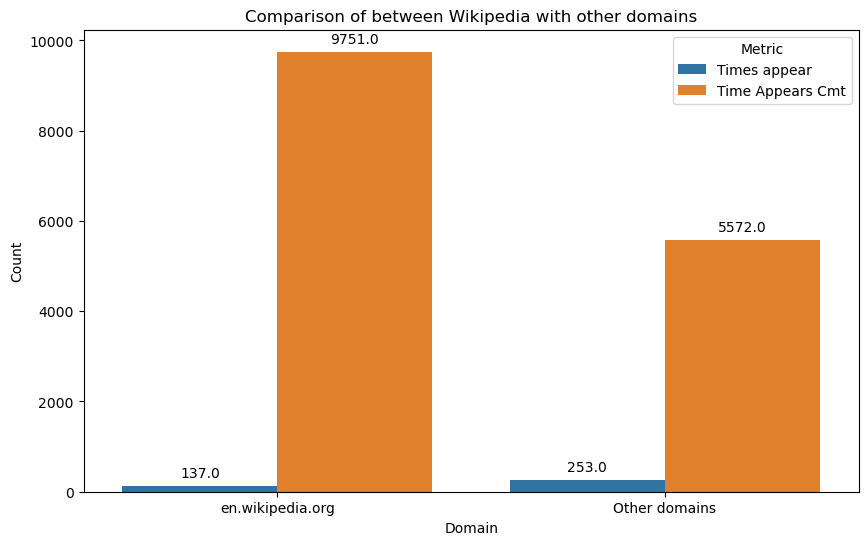

In [845]:
# Melt the DataFrame to make it suitable for plotting
df_melted = url_complete_with_total.melt(id_vars="domain", var_name="Metric", value_name="Value")

# Plot
plt.figure(figsize=(10, 6))
axes = sns.barplot(data=df_melted, x="domain", y="Value", hue="Metric")

# Add annotations
for p in ax.patches:
    axes.annotate(format(p.get_height(), ".1f"), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = "center", va = "center", 
                xytext = (0, 9), 
                textcoords = "offset points")

plt.title("Comparison of between Wikipedia with other domains")
plt.xlabel("Domain")
plt.ylabel("Count")
plt.legend(title="Metric")
plt.show()

##### The bar plot unmistakably illustrates that URLs are more commonly present in comments than in the main posts. This trend is logical since individuals frequently incorporate references in their comments to reinforce their ideas and perspectives. It underscores the interactive and collaborative nature of discussions within online communities, where participants strive to enrich their contributions by providing external sources for credibility and further exploration.

##### More interestingly , the fact that Wikipedia is mentioned much more frequently in comments compared to all other websites combined suggests that people find it extremely useful. They rely on it for detailed and trustworthy information on a wide range of topics. When they include Wikipedia links in their comments, it's a way of showing that they've done their research and want to back up what they're saying with solid evidence.

##### In essence, the high frequency of Wikipedia mentions in comments reflects its central role as a source of knowledge and a catalyst for online interaction.

##### Next, we'll focus on analyzing how the sentiments expressed in the titles and bodies relate to the sentiments of the associated comments, as well as how the length of the content in both titles and bodies influences these sentiments.

##### Let's determine which topic receives the most mentions in our Stack Exchange data.

In [846]:
tag_df.sort_values(by = "Count",ascending = False)

,Id,TagName,Count,ExcerptPostId,WikiPostId
7,13,world-war-two,1591,44.0,43.0
81,162,united-states,1548,1485.0,1484.0
45,87,military,963,950.0,949.0
36,74,middle-ages,877,1487.0,1486.0
107,207,ancient-history,750,958.0,957.0
...,...,...,...,...,...
783,3101,post-war-japan,1,60156.0,60155.0
777,3088,nassau,1,59820.0,59819.0
774,3072,teutonic-order,1,59244.0,59243.0
710,2846,asdic,1,50056.0,50055.0


It appears that World War II is the most frequently discussed topic in our dataset. Now, let's delve into its analysis.

In [847]:
# Initialize a pre-trained sentiment analysis model called "cardiffnlp/twitter-roberta-base-sentiment" 
# using the Hugging Face Transformers library
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [848]:
# Function to get the sentiment score
def polarity_scores_roberta(text):
    if isinstance(text, str):
        encoded_text = tokenizer(text, return_tensors='pt',max_length = 512)
        output = model(**encoded_text)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        
        # Calculate the compound score of the sentiment score
        # Basically the -1 represent the extreme negative , 0 : neutral , 1 is extreme postive
        return (scores[0] * -1) + (scores[1] * 0) + (scores[2] * 1 )
        
    # If the text is nan return it as neutral 
    else: 
        return 0

# Function to remove special keywords
def remove_special_keywords(text):
    cleaned_text = re.sub(r'[!@#$%^&*]', '', text)
    return cleaned_text

In [849]:
# Test the function
negative_text = "Hi I really really hate you"
print("Negative score: ",polarity_scores_roberta(negative_text))
print("=" * 20)
      
neutral_text = "Hi"
print("Neutral score: ",polarity_scores_roberta(neutral_text))
print("="* 20)

positive_text = "Hi I incredibly like you a lot"
print("Positive score: ",polarity_scores_roberta(positive_text))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Negative score:  -0.9662588038481772
Neutral score:  0.10823990404605865
Positive score:  0.967550496570766


In [850]:
# Create a new dataframe represents represent the posts that related to WW2
ww2_df_post = post_df[post_df["Tags"].str.contains(r'\bworld-war-two\b')].reset_index(drop = True)
ww2_df_post

,Id,PostTypeId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorUserId,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,ContentLicense
0,22,1,2011-10-11T20:14:35.147,16,4688.0,"<p>During World War 2, what government branche...",45.0,961.0,2013-02-08T15:30:36.553,2019-07-31T02:03:50.747,German Government branches during World War 2,|20th-century|world-war-two|nazi-germany|germany|,1.0,0,CC BY-SA 3.0
1,23,1,2011-10-11T20:15:14.500,38,13491.0,<p>There are accounts that British Prime Minis...,18.0,85.0,2012-06-14T17:45:02.680,2019-09-28T15:53:47.793,Why did Chamberlain act to appease Hitler lead...,|world-war-two|20th-century|,8.0,1,CC BY-SA 3.0
2,25,1,2011-10-11T20:23:09.860,28,523405.0,<p>How many troops (allied and axis) died at N...,16.0,17887.0,2020-04-26T08:21:49.820,2020-04-26T08:21:49.820,How many troops died on D-day?,|world-war-two|20th-century|dday|ww2-european-...,2.0,1,CC BY-SA 3.0
3,27,1,2011-10-11T20:28:09.197,97,62285.0,<p>Japan and the Soviet Union shared a common ...,9.0,17887.0,2020-04-17T13:39:52.473,2020-04-17T13:39:52.473,Why didn't Imperial Japan attack the Soviet Un...,|world-war-two|20th-century|soviet-union|japan...,12.0,9,CC BY-SA 3.0
4,46,1,2011-10-11T20:57:50.930,9,17162.0,<p>I am interested in mapping the pre-war (WWI...,62.0,62.0,2015-08-29T23:37:50.827,2017-07-06T21:12:26.617,Where was the pre-war (ww2) border between Pol...,|20th-century|world-war-two|germany|poland|geo...,6.0,3,CC BY-SA 3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1584,74388,1,2024-02-12T20:32:32.257,9,1857.0,"<p>In Hitler’s last will and testament, he ass...",22453.0,NaN,NaN,2024-02-13T10:25:44.313,What exactly was the position of ‘Party Minist...,|world-war-two|nazi-germany|germany|hitler|naz...,2.0,5,CC BY-SA 4.0
1585,75526,1,2024-03-17T21:37:24.857,4,195.0,<p>Recently I found a Bellingcat article title...,38316.0,38316.0,2024-03-17T22:33:21.500,2024-03-17T22:33:21.500,Does this WWII photo show a double-track railway?,|world-war-two|photography|railroads|photograph|,0.0,1,CC BY-SA 4.0
1586,75538,1,2024-03-19T04:17:46.123,-1,166.0,"<p>Many Germans, even before World War I, beli...",52417.0,52417.0,2024-03-19T17:01:45.413,2024-03-19T17:45:23.620,Why didn't the promise of the imminent Green R...,|world-war-two|agriculture|,2.0,5,CC BY-SA 4.0
1587,75564,1,2024-03-21T11:22:46.497,1,240.0,"<p>There's a <a href=""https://cjil.uchicago.ed...",27431.0,27431.0,2024-03-21T11:28:04.713,2024-04-06T19:23:31.240,When and where did the Allies use starvation t...,|world-war-two|military|starvation|,2.0,12,CC BY-SA 4.0


In [851]:
# Again remove html tags for the Body
ww2_df_post["Clean_Body"] =ww2_df_post["Body"].apply(remove_html_tags)
ww2_df_post

,Id,PostTypeId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorUserId,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,ContentLicense,Clean_Body
0,22,1,2011-10-11T20:14:35.147,16,4688.0,"<p>During World War 2, what government branche...",45.0,961.0,2013-02-08T15:30:36.553,2019-07-31T02:03:50.747,German Government branches during World War 2,|20th-century|world-war-two|nazi-germany|germany|,1.0,0,CC BY-SA 3.0,"During World War 2, what government branches, ..."
1,23,1,2011-10-11T20:15:14.500,38,13491.0,<p>There are accounts that British Prime Minis...,18.0,85.0,2012-06-14T17:45:02.680,2019-09-28T15:53:47.793,Why did Chamberlain act to appease Hitler lead...,|world-war-two|20th-century|,8.0,1,CC BY-SA 3.0,There are accounts that British Prime Minister...
2,25,1,2011-10-11T20:23:09.860,28,523405.0,<p>How many troops (allied and axis) died at N...,16.0,17887.0,2020-04-26T08:21:49.820,2020-04-26T08:21:49.820,How many troops died on D-day?,|world-war-two|20th-century|dday|ww2-european-...,2.0,1,CC BY-SA 3.0,How many troops (allied and axis) died at Norm...
3,27,1,2011-10-11T20:28:09.197,97,62285.0,<p>Japan and the Soviet Union shared a common ...,9.0,17887.0,2020-04-17T13:39:52.473,2020-04-17T13:39:52.473,Why didn't Imperial Japan attack the Soviet Un...,|world-war-two|20th-century|soviet-union|japan...,12.0,9,CC BY-SA 3.0,Japan and the Soviet Union shared a common bor...
4,46,1,2011-10-11T20:57:50.930,9,17162.0,<p>I am interested in mapping the pre-war (WWI...,62.0,62.0,2015-08-29T23:37:50.827,2017-07-06T21:12:26.617,Where was the pre-war (ww2) border between Pol...,|20th-century|world-war-two|germany|poland|geo...,6.0,3,CC BY-SA 3.0,I am interested in mapping the pre-war (WWII) ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1584,74388,1,2024-02-12T20:32:32.257,9,1857.0,"<p>In Hitler’s last will and testament, he ass...",22453.0,NaN,NaN,2024-02-13T10:25:44.313,What exactly was the position of ‘Party Minist...,|world-war-two|nazi-germany|germany|hitler|naz...,2.0,5,CC BY-SA 4.0,"In Hitler’s last will and testament, he assign..."
1585,75526,1,2024-03-17T21:37:24.857,4,195.0,<p>Recently I found a Bellingcat article title...,38316.0,38316.0,2024-03-17T22:33:21.500,2024-03-17T22:33:21.500,Does this WWII photo show a double-track railway?,|world-war-two|photography|railroads|photograph|,0.0,1,CC BY-SA 4.0,Recently I found a Bellingcat article titled S...
1586,75538,1,2024-03-19T04:17:46.123,-1,166.0,"<p>Many Germans, even before World War I, beli...",52417.0,52417.0,2024-03-19T17:01:45.413,2024-03-19T17:45:23.620,Why didn't the promise of the imminent Green R...,|world-war-two|agriculture|,2.0,5,CC BY-SA 4.0,"Many Germans, even before World War I, believe..."
1587,75564,1,2024-03-21T11:22:46.497,1,240.0,"<p>There's a <a href=""https://cjil.uchicago.ed...",27431.0,27431.0,2024-03-21T11:28:04.713,2024-04-06T19:23:31.240,When and where did the Allies use starvation t...,|world-war-two|military|starvation|,2.0,12,CC BY-SA 4.0,There's a paper that claims in relation to the...


In [852]:
# Remove special keywords for the Cleanned Body and the Title
ww2_df_post["Clean_Body"] = ww2_df_post["Clean_Body"].apply(remove_special_keywords)
ww2_df_post["Title"] =  ww2_df_post["Title"].apply(remove_special_keywords)
ww2_df_post.head()

,Id,PostTypeId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorUserId,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,ContentLicense,Clean_Body
0,22,1,2011-10-11T20:14:35.147,16,4688.0,"<p>During World War 2, what government branche...",45.0,961.0,2013-02-08T15:30:36.553,2019-07-31T02:03:50.747,German Government branches during World War 2,|20th-century|world-war-two|nazi-germany|germany|,1.0,0,CC BY-SA 3.0,"During World War 2, what government branches, ..."
1,23,1,2011-10-11T20:15:14.500,38,13491.0,<p>There are accounts that British Prime Minis...,18.0,85.0,2012-06-14T17:45:02.680,2019-09-28T15:53:47.793,Why did Chamberlain act to appease Hitler lead...,|world-war-two|20th-century|,8.0,1,CC BY-SA 3.0,There are accounts that British Prime Minister...
2,25,1,2011-10-11T20:23:09.860,28,523405.0,<p>How many troops (allied and axis) died at N...,16.0,17887.0,2020-04-26T08:21:49.820,2020-04-26T08:21:49.820,How many troops died on D-day?,|world-war-two|20th-century|dday|ww2-european-...,2.0,1,CC BY-SA 3.0,How many troops (allied and axis) died at Norm...
3,27,1,2011-10-11T20:28:09.197,97,62285.0,<p>Japan and the Soviet Union shared a common ...,9.0,17887.0,2020-04-17T13:39:52.473,2020-04-17T13:39:52.473,Why didn't Imperial Japan attack the Soviet Un...,|world-war-two|20th-century|soviet-union|japan...,12.0,9,CC BY-SA 3.0,Japan and the Soviet Union shared a common bor...
4,46,1,2011-10-11T20:57:50.930,9,17162.0,<p>I am interested in mapping the pre-war (WWI...,62.0,62.0,2015-08-29T23:37:50.827,2017-07-06T21:12:26.617,Where was the pre-war (ww2) border between Pol...,|20th-century|world-war-two|germany|poland|geo...,6.0,3,CC BY-SA 3.0,I am interested in mapping the pre-war (WWII) ...


In [853]:
# Narrow down our dataframe to make it contains the Title the body and the PostTypeId
ww2_df_post = ww2_df_post[["Id","Clean_Body","Title"]]
ww2_df_post

,Id,Clean_Body,Title
0,22,"During World War 2, what government branches, ...",German Government branches during World War 2
1,23,There are accounts that British Prime Minister...,Why did Chamberlain act to appease Hitler lead...
2,25,How many troops (allied and axis) died at Norm...,How many troops died on D-day?
3,27,Japan and the Soviet Union shared a common bor...,Why didn't Imperial Japan attack the Soviet Un...
4,46,I am interested in mapping the pre-war (WWII) ...,Where was the pre-war (ww2) border between Pol...
...,...,...,...
1584,74388,"In Hitler’s last will and testament, he assign...",What exactly was the position of ‘Party Minist...
1585,75526,Recently I found a Bellingcat article titled S...,Does this WWII photo show a double-track railway?
1586,75538,"Many Germans, even before World War I, believe...",Why didn't the promise of the imminent Green R...
1587,75564,There's a paper that claims in relation to the...,When and where did the Allies use starvation t...


In [854]:
# Let's have a look at the newly cleanned dataframe to check if there are 
#any null values in our title and body
ww2_df_post.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1589 entries, 0 to 1588
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Id          1589 non-null   int64 
 1   Clean_Body  1589 non-null   object
 2   Title       1589 non-null   object
dtypes: int64(1), object(2)
memory usage: 37.4+ KB


Let's determine the polarity score for the titles and their corresponding bodies.

In [855]:
# Body Score
ww2_df_post["Body Score"] = ww2_df_post["Clean_Body"].apply(polarity_scores_roberta)
ww2_df_post.head()

C:\Users\thinh\AppData\Local\Temp\ipykernel_31980\3558292138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ww2_df_post["Body Score"] = ww2_df_post["Clean_Body"].apply(polarity_scores_roberta)


,Id,Clean_Body,Title,Body Score
0,22,"During World War 2, what government branches, ...",German Government branches during World War 2,-0.462669
1,23,There are accounts that British Prime Minister...,Why did Chamberlain act to appease Hitler lead...,-0.590581
2,25,How many troops (allied and axis) died at Norm...,How many troops died on D-day?,-0.766205
3,27,Japan and the Soviet Union shared a common bor...,Why didn't Imperial Japan attack the Soviet Un...,-0.335204
4,46,I am interested in mapping the pre-war (WWII) ...,Where was the pre-war (ww2) border between Pol...,0.063665


In [856]:
# Calculate the polarity score of the title
ww2_df_post["Title Score"] = ww2_df_post["Title"].apply(polarity_scores_roberta)
ww2_df_post.head()

C:\Users\thinh\AppData\Local\Temp\ipykernel_31980\926825124.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ww2_df_post["Title Score"] = ww2_df_post["Title"].apply(polarity_scores_roberta)


,Id,Clean_Body,Title,Body Score,Title Score
0,22,"During World War 2, what government branches, ...",German Government branches during World War 2,-0.462669,-0.440161
1,23,There are accounts that British Prime Minister...,Why did Chamberlain act to appease Hitler lead...,-0.590581,-0.573242
2,25,How many troops (allied and axis) died at Norm...,How many troops died on D-day?,-0.766205,-0.735738
3,27,Japan and the Soviet Union shared a common bor...,Why didn't Imperial Japan attack the Soviet Un...,-0.335204,-0.421336
4,46,I am interested in mapping the pre-war (WWII) ...,Where was the pre-war (ww2) border between Pol...,0.063665,-0.135447


Once we've computed the polarity scores for the titles and bodies, our next step involves generating columns that depict the length of the text in both titles and their respective bodies.

In [857]:
# Titles
ww2_df_post["Length Title"] = ww2_df_post["Title"].apply(lambda text : len(text))

# Bodies 
ww2_df_post["Length Body"] = ww2_df_post["Clean_Body"].apply(lambda text: len(text))
ww2_df_post

C:\Users\thinh\AppData\Local\Temp\ipykernel_31980\2619252886.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ww2_df_post["Length Title"] = ww2_df_post["Title"].apply(lambda text : len(text))
C:\Users\thinh\AppData\Local\Temp\ipykernel_31980\2619252886.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ww2_df_post["Length Body"] = ww2_df_post["Clean_Body"].apply(lambda text: len(text))


,Id,Clean_Body,Title,Body Score,Title Score,Length Title,Length Body
0,22,"During World War 2, what government branches, ...",German Government branches during World War 2,-0.462669,-0.440161,45,179
1,23,There are accounts that British Prime Minister...,Why did Chamberlain act to appease Hitler lead...,-0.590581,-0.573242,84,444
2,25,How many troops (allied and axis) died at Norm...,How many troops died on D-day?,-0.766205,-0.735738,30,148
3,27,Japan and the Soviet Union shared a common bor...,Why didn't Imperial Japan attack the Soviet Un...,-0.335204,-0.421336,69,378
4,46,I am interested in mapping the pre-war (WWII) ...,Where was the pre-war (ww2) border between Pol...,0.063665,-0.135447,62,281
...,...,...,...,...,...,...,...
1584,74388,"In Hitler’s last will and testament, he assign...",What exactly was the position of ‘Party Minist...,-0.417163,-0.328712,94,656
1585,75526,Recently I found a Bellingcat article titled S...,Does this WWII photo show a double-track railway?,-0.192908,-0.033086,49,1874
1586,75538,"Many Germans, even before World War I, believe...",Why didn't the promise of the imminent Green R...,-0.270615,-0.433834,119,2305
1587,75564,There's a paper that claims in relation to the...,When and where did the Allies use starvation t...,-0.293305,-0.349883,60,567


##### Next, we'll generate word clouds to identify the most commonly appeared words in the bodies of posts categorized under different sentiments: negative, neutral, and positive.

Initially, we'll create a new dataframe that includes bodies along with their polarity scores. Then, we'll classify the sentiments of these bodies based on their polarity scores.

In [858]:
# Extract appropriate columns
word_cloud_df = ww2_df_post[["Clean_Body","Body Score"]]
word_cloud_df

,Clean_Body,Body Score
0,"During World War 2, what government branches, ...",-0.462669
1,There are accounts that British Prime Minister...,-0.590581
2,How many troops (allied and axis) died at Norm...,-0.766205
3,Japan and the Soviet Union shared a common bor...,-0.335204
4,I am interested in mapping the pre-war (WWII) ...,0.063665
...,...,...
1584,"In Hitler’s last will and testament, he assign...",-0.417163
1585,Recently I found a Bellingcat article titled S...,-0.192908
1586,"Many Germans, even before World War I, believe...",-0.270615
1587,There's a paper that claims in relation to the...,-0.293305


In [859]:
# Funtion to return the sentiment of the text based on its sentiment score
def classify_sentiment(score):
    if score < -0.2:
        return "Negative"
    elif score > 0.2:
        return "Positive"
    else:
        return "Neutral"


In [860]:
word_cloud_df["Sentiment"] = word_cloud_df["Body Score"].apply(classify_sentiment)
word_cloud_df

C:\Users\thinh\AppData\Local\Temp\ipykernel_31980\652859580.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  word_cloud_df["Sentiment"] = word_cloud_df["Body Score"].apply(classify_sentiment)


,Clean_Body,Body Score,Sentiment
0,"During World War 2, what government branches, ...",-0.462669,Negative
1,There are accounts that British Prime Minister...,-0.590581,Negative
2,How many troops (allied and axis) died at Norm...,-0.766205,Negative
3,Japan and the Soviet Union shared a common bor...,-0.335204,Negative
4,I am interested in mapping the pre-war (WWII) ...,0.063665,Neutral
...,...,...,...
1584,"In Hitler’s last will and testament, he assign...",-0.417163,Negative
1585,Recently I found a Bellingcat article titled S...,-0.192908,Neutral
1586,"Many Germans, even before World War I, believe...",-0.270615,Negative
1587,There's a paper that claims in relation to the...,-0.293305,Negative


In [861]:
# Function to generate word cloud
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=600, height=300, background_color="white", prefer_horizontal=0.9).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

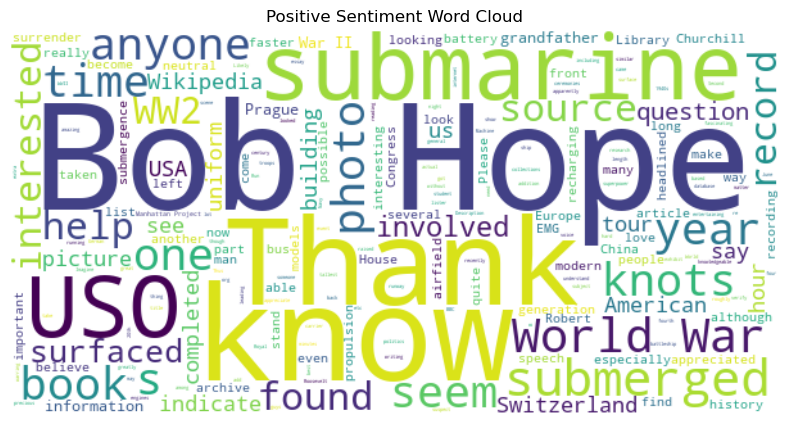

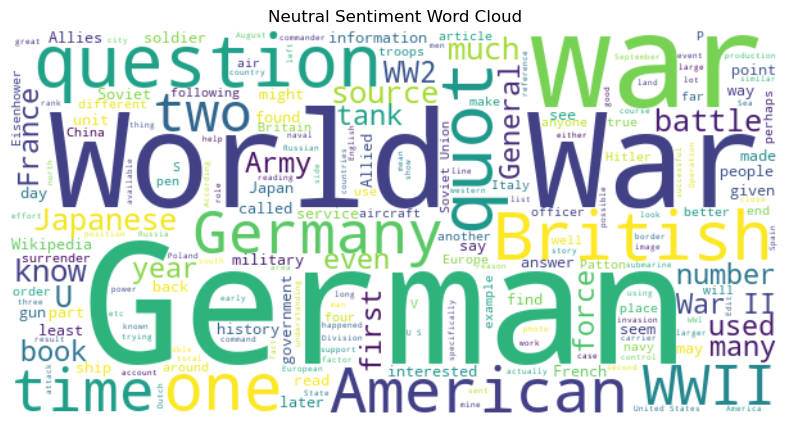

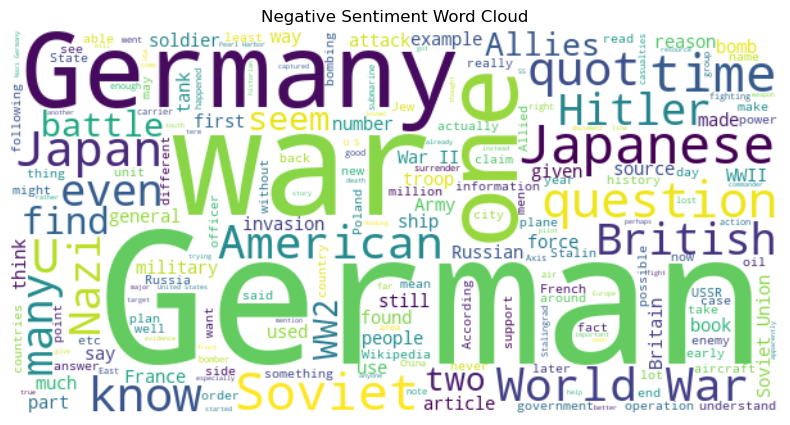

In [862]:
# Generate word clouds for each sentiment group
# Positive group
positive_posts_text = " ".join(word_cloud_df[word_cloud_df["Sentiment"] == "Positive"]["Clean_Body"])
generate_word_cloud(positive_posts_text, "Positive Sentiment Word Cloud")

# Neutral group
neutral_posts_text = " ".join(word_cloud_df[word_cloud_df["Sentiment"] == "Neutral"]["Clean_Body"])
generate_word_cloud(neutral_posts_text, "Neutral Sentiment Word Cloud")

# Negative group
negative_posts_text = " ".join(word_cloud_df[word_cloud_df["Sentiment"] == "Negative"]["Clean_Body"])
generate_word_cloud(negative_posts_text, "Negative Sentiment Word Cloud")

##### From the word clouds, we observe that the size of words corresponds to their frequency in the text. Larger words indicate higher occurrence. In the positive sentiment group, prominent words like "Thank" and "Hope" signify positive emotions. These words, expressing gratitude and optimism, are more prevalent in texts with positive sentiments. Thus, analyzing these word clouds offers insights into the prevailing positive themes and emotions conveyed in the text.

##### In the neutral sentiment word cloud, we notice that country names and general terms like "World War" are more prominent. This makes sense, as these words convey general information without expressing specific emotions.

##### Interestingly, in the negative sentiment word cloud, words like "War" are prominent, reflecting themes of fatality and death, which clearly indicate negative emotions. Additionally, country names such as Germany and Japan, along with nationalities like German and Japanese, are frequently mentioned. This is likely because these countries were associated with the Nazis, thus evoking negative sentiments.

Next, we'll analyze the comments by calculating their sentiment scores.

In [863]:
# Get the Ids of the posts related to World War 2
ww2_post_ids = ww2_df_post["Id"]

# Filter out comments related to World War 2 posts
ww2_cmt_df = cmt_df[cmt_df["PostId"].isin(ww2_post_ids)].reset_index(drop = True)
ww2_cmt_df

,Id,PostId,Score,Text,CreationDate,UserId
0,83,46,3,Please keep in mind that Poland also had a bor...,2011-10-11T21:18:36.073,26.0
1,122,64,9,Note that the US was already fairly involved i...,2011-10-12T07:01:48.573,22.0
2,228,215,13,As a simple non-researched answer (I will atte...,2011-10-13T01:16:32.633,12.0
3,327,199,1,"I must admit, this is the most interesting que...",2011-10-13T22:28:57.897,16.0
4,332,215,12,"As an American, I have never heard of this.",2011-10-13T22:42:15.993,54.0
...,...,...,...,...,...,...
7223,242695,75564,1,"I know you said ""Allies"" but let's not forget ...",2024-03-22T08:52:16.947,1372.0
7224,242697,75564,0,And had there been no atomic bombs and no inva...,2024-03-22T12:59:04.500,33565.0
7225,242713,75564,0,In Europe both sides used naval blockades in w...,2024-03-23T08:17:31.607,3164.0
7226,242746,75581,2,You are looking at the War Department general ...,2024-03-24T14:34:48.410,33565.0


In [864]:
# Filter out special keywords in the comments text
ww2_cmt_df = ww2_cmt_df[["PostId","Text"]]
ww2_cmt_df["Text"] = ww2_cmt_df["Text"].apply(remove_special_keywords)
ww2_cmt_df

C:\Users\thinh\AppData\Local\Temp\ipykernel_31980\881125226.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ww2_cmt_df["Text"] = ww2_cmt_df["Text"].apply(remove_special_keywords)


,PostId,Text
0,46,Please keep in mind that Poland also had a bor...
1,64,Note that the US was already fairly involved i...
2,215,As a simple non-researched answer (I will atte...
3,199,"I must admit, this is the most interesting que..."
4,215,"As an American, I have never heard of this."
...,...,...
7223,75564,"I know you said ""Allies"" but let's not forget ..."
7224,75564,And had there been no atomic bombs and no inva...
7225,75564,In Europe both sides used naval blockades in w...
7226,75581,You are looking at the War Department general ...


In [865]:
# Calculate the polarity score of the filtered comments
ww2_cmt_df["Comment Score"] = ww2_cmt_df["Text"].apply(polarity_scores_roberta)
ww2_cmt_df.head()

C:\Users\thinh\AppData\Local\Temp\ipykernel_31980\1700325317.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ww2_cmt_df["Comment Score"] = ww2_cmt_df["Text"].apply(polarity_scores_roberta)


,PostId,Text,Comment Score
0,46,Please keep in mind that Poland also had a bor...,-0.284147
1,64,Note that the US was already fairly involved i...,-0.206081
2,215,As a simple non-researched answer (I will atte...,-0.478339
3,199,"I must admit, this is the most interesting que...",0.954065
4,215,"As an American, I have never heard of this.",-0.563590


In [866]:
# Calcualte the Average polarity score for each post
# Since one post can have many comments so we need to calculate the mean values
avg_ww2_cmt = ww2_cmt_df.groupby("PostId")[["Comment Score"]].mean().reset_index()
avg_ww2_cmt

,PostId,Comment Score
0,23,0.977588
1,25,0.934179
2,27,-0.462330
3,46,0.533650
4,64,-0.383542
...,...,...
1369,74388,0.198546
1370,75526,-0.594684
1371,75538,0.314779
1372,75564,-0.465143


Let's have a look again about the two dataframes we've created—one for posts and one for comments.

In [867]:
print("Dataframe represents the Post Sentiment:")
display(ww2_df_post)

print("Dataframe represent the Comment Sentiment:")
display(avg_ww2_cmt)

Dataframe represents the Post Sentiment:


,Id,Clean_Body,Title,Body Score,Title Score,Length Title,Length Body
0,22,"During World War 2, what government branches, ...",German Government branches during World War 2,-0.462669,-0.440161,45,179
1,23,There are accounts that British Prime Minister...,Why did Chamberlain act to appease Hitler lead...,-0.590581,-0.573242,84,444
2,25,How many troops (allied and axis) died at Norm...,How many troops died on D-day?,-0.766205,-0.735738,30,148
3,27,Japan and the Soviet Union shared a common bor...,Why didn't Imperial Japan attack the Soviet Un...,-0.335204,-0.421336,69,378
4,46,I am interested in mapping the pre-war (WWII) ...,Where was the pre-war (ww2) border between Pol...,0.063665,-0.135447,62,281
...,...,...,...,...,...,...,...
1584,74388,"In Hitler’s last will and testament, he assign...",What exactly was the position of ‘Party Minist...,-0.417163,-0.328712,94,656
1585,75526,Recently I found a Bellingcat article titled S...,Does this WWII photo show a double-track railway?,-0.192908,-0.033086,49,1874
1586,75538,"Many Germans, even before World War I, believe...",Why didn't the promise of the imminent Green R...,-0.270615,-0.433834,119,2305
1587,75564,There's a paper that claims in relation to the...,When and where did the Allies use starvation t...,-0.293305,-0.349883,60,567


Dataframe represent the Comment Sentiment:


,PostId,Comment Score
0,23,0.977588
1,25,0.934179
2,27,-0.462330
3,46,0.533650
4,64,-0.383542
...,...,...
1369,74388,0.198546
1370,75526,-0.594684
1371,75538,0.314779
1372,75564,-0.465143


Next, let's combine the two dataframes by merging them on the PostId column.

In [868]:
# First we need to rename our post dataframe to make it the same name Id to be
# able to merge the 2 dataframes
ww2_df_post.rename(columns = {"Id":"PostId"},inplace = True)
ww2_df_post

C:\Users\thinh\AppData\Local\Temp\ipykernel_31980\3804358437.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ww2_df_post.rename(columns = {"Id":"PostId"},inplace = True)


,PostId,Clean_Body,Title,Body Score,Title Score,Length Title,Length Body
0,22,"During World War 2, what government branches, ...",German Government branches during World War 2,-0.462669,-0.440161,45,179
1,23,There are accounts that British Prime Minister...,Why did Chamberlain act to appease Hitler lead...,-0.590581,-0.573242,84,444
2,25,How many troops (allied and axis) died at Norm...,How many troops died on D-day?,-0.766205,-0.735738,30,148
3,27,Japan and the Soviet Union shared a common bor...,Why didn't Imperial Japan attack the Soviet Un...,-0.335204,-0.421336,69,378
4,46,I am interested in mapping the pre-war (WWII) ...,Where was the pre-war (ww2) border between Pol...,0.063665,-0.135447,62,281
...,...,...,...,...,...,...,...
1584,74388,"In Hitler’s last will and testament, he assign...",What exactly was the position of ‘Party Minist...,-0.417163,-0.328712,94,656
1585,75526,Recently I found a Bellingcat article titled S...,Does this WWII photo show a double-track railway?,-0.192908,-0.033086,49,1874
1586,75538,"Many Germans, even before World War I, believe...",Why didn't the promise of the imminent Green R...,-0.270615,-0.433834,119,2305
1587,75564,There's a paper that claims in relation to the...,When and where did the Allies use starvation t...,-0.293305,-0.349883,60,567


In [869]:
complete_sentiment_df = pd.merge(ww2_df_post, avg_ww2_cmt , on = "PostId", how = "left" )
complete_sentiment_df


,PostId,Clean_Body,Title,Body Score,Title Score,Length Title,Length Body,Comment Score
0,22,"During World War 2, what government branches, ...",German Government branches during World War 2,-0.462669,-0.440161,45,179,NaN
1,23,There are accounts that British Prime Minister...,Why did Chamberlain act to appease Hitler lead...,-0.590581,-0.573242,84,444,0.977588
2,25,How many troops (allied and axis) died at Norm...,How many troops died on D-day?,-0.766205,-0.735738,30,148,0.934179
3,27,Japan and the Soviet Union shared a common bor...,Why didn't Imperial Japan attack the Soviet Un...,-0.335204,-0.421336,69,378,-0.462330
4,46,I am interested in mapping the pre-war (WWII) ...,Where was the pre-war (ww2) border between Pol...,0.063665,-0.135447,62,281,0.533650
...,...,...,...,...,...,...,...,...
1584,74388,"In Hitler’s last will and testament, he assign...",What exactly was the position of ‘Party Minist...,-0.417163,-0.328712,94,656,0.198546
1585,75526,Recently I found a Bellingcat article titled S...,Does this WWII photo show a double-track railway?,-0.192908,-0.033086,49,1874,-0.594684
1586,75538,"Many Germans, even before World War I, believe...",Why didn't the promise of the imminent Green R...,-0.270615,-0.433834,119,2305,0.314779
1587,75564,There's a paper that claims in relation to the...,When and where did the Allies use starvation t...,-0.293305,-0.349883,60,567,-0.465143


In [870]:
# Check the general information of the merged dataframe as well as checking null values
print("General Information:")
display(complete_sentiment_df.describe())

print("Checking Null Values:")
display(complete_sentiment_df.info())

General Information:


,PostId,Body Score,Title Score,Length Title,Length Body,Comment Score
count,1589.000000,1589.000000,1589.000000,1589.000000,1589.000000,1374.000000
mean,39067.859031,-0.359960,-0.298876,71.979232,847.863436,-0.204779
std,20958.573784,0.231066,0.210853,24.740929,820.448687,0.257666
min,22.000000,-0.963766,-0.919497,15.000000,32.000000,-0.958195
25%,22763.000000,-0.504959,-0.450360,55.000000,368.000000,-0.372827
50%,41095.000000,-0.372045,-0.264101,69.000000,617.000000,-0.232889
75%,56081.000000,-0.229769,-0.128669,87.000000,1050.000000,-0.081376
max,75581.000000,0.894528,0.512722,150.000000,8850.000000,0.986530


Checking Null Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1589 entries, 0 to 1588
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PostId         1589 non-null   int64  
 1   Clean_Body     1589 non-null   object 
 2   Title          1589 non-null   object 
 3   Body Score     1589 non-null   float64
 4   Title Score    1589 non-null   float64
 5   Length Title   1589 non-null   int64  
 6   Length Body    1589 non-null   int64  
 7   Comment Score  1374 non-null   float64
dtypes: float64(3), int64(3), object(2)
memory usage: 99.4+ KB


None

First, we notice that the Comment Score column contains some null values. Instead of simply deleting these rows, we'll use a random sampling technique to replace the null values.

But we will firstly check the performance of it compared to other imputation techniques such as the mean and median imputation.

In [871]:
# Mean values
mean_value = complete_sentiment_df["Comment Score"].mean()
mean_impt = complete_sentiment_df["Comment Score"].fillna(mean_value)

# Median value 
median = complete_sentiment_df["Comment Score"].median()
median_impt = complete_sentiment_df["Comment Score"].fillna(median)


# Random sample imputation
def random_sample_imputation(df):
    cols_with_missing_values = df.columns[df.isna().any()].tolist()

    for var in cols_with_missing_values:
        # extract a random sample
        random_sample_df = df[var].dropna().sample(df[var].isnull().sum(), replace=True, random_state=0)
        # re-index the randomly extracted sample
        random_sample_df.index = df[df[var].isnull()].index
        # replace the NA
        df.loc[df[var].isnull(), var] = random_sample_df.values

    return df

random_impt = random_sample_imputation(complete_sentiment_df[["Comment Score"]])

C:\Users\thinh\AppData\Local\Temp\ipykernel_31980\1487536339.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[var].isnull(), var] = random_sample_df.values


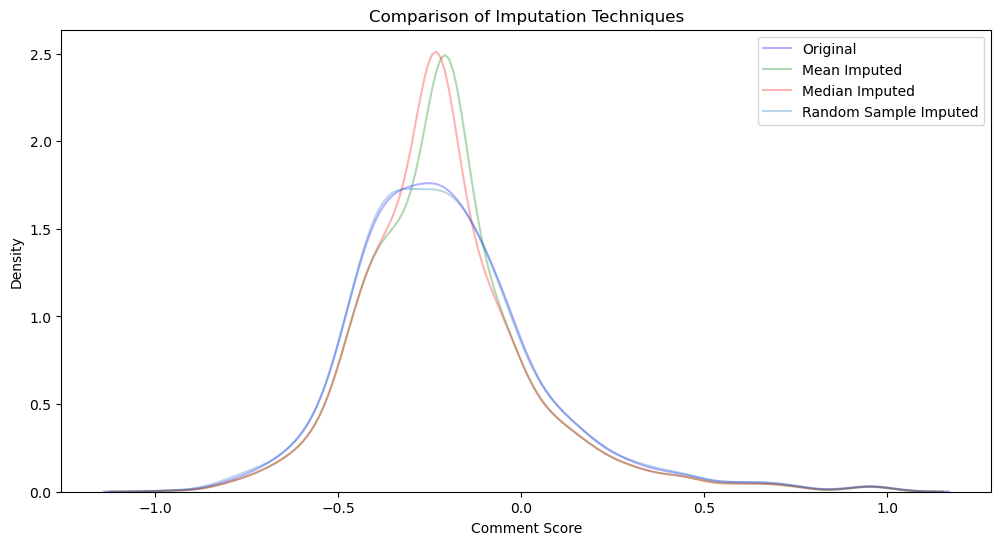

In [872]:
# Plotting part

# Original data
original_data = complete_sentiment_df["Comment Score"]

# Plotting the distributions
plt.figure(figsize=(12, 6))

# Original data
sns.kdeplot(original_data, label="Original", color="blue", alpha=0.3)

# Mean imputed data
sns.kdeplot(mean_impt, label="Mean Imputed", color="green",  alpha=0.3)

# Median imputed data
sns.kdeplot(median_impt, label="Median Imputed", color="red",alpha=0.3)

# Random sample imputed data
sns.kdeplot(random_impt, label="Random Sample Imputed", color="purple",alpha=0.3)

plt.title("Comparison of Imputation Techniques")
plt.xlabel("Comment Score")
plt.ylabel("Density")
plt.legend()
plt.show()

Based on the distribution of the data generated by different imputation techniques, we observe that the random sample imputation technique preserves the original data's distribution most accurately.

In [873]:
# Filling NA values
complete_sentiment_df["Comment Score"] = random_sample_imputation(complete_sentiment_df[["Comment Score"]])

C:\Users\thinh\AppData\Local\Temp\ipykernel_31980\1487536339.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[var].isnull(), var] = random_sample_df.values


In [874]:
# Check the Null values again 
complete_sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1589 entries, 0 to 1588
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PostId         1589 non-null   int64  
 1   Clean_Body     1589 non-null   object 
 2   Title          1589 non-null   object 
 3   Body Score     1589 non-null   float64
 4   Title Score    1589 non-null   float64
 5   Length Title   1589 non-null   int64  
 6   Length Body    1589 non-null   int64  
 7   Comment Score  1589 non-null   float64
dtypes: float64(3), int64(3), object(2)
memory usage: 99.4+ KB


Another important point is that some columns, like the length of the body and titles, have a wide range of values. Therefore, we need to standardize our dataframe to ensure the values are on a similar scale.

In [875]:
# Simply remove our unnecessary columns 
complete_sentiment_df.drop(columns = ["PostId","Clean_Body","Title"],inplace = True)
complete_sentiment_df

,Body Score,Title Score,Length Title,Length Body,Comment Score
0,-0.462669,-0.440161,45,179,-0.031729
1,-0.590581,-0.573242,84,444,0.977588
2,-0.766205,-0.735738,30,148,0.934179
3,-0.335204,-0.421336,69,378,-0.462330
4,0.063665,-0.135447,62,281,0.533650
...,...,...,...,...,...
1584,-0.417163,-0.328712,94,656,0.198546
1585,-0.192908,-0.033086,49,1874,-0.594684
1586,-0.270615,-0.433834,119,2305,0.314779
1587,-0.293305,-0.349883,60,567,-0.465143


In [876]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Apply the scaler to the selected columns
std_df = scaler.fit_transform(complete_sentiment_df)
std_df = pd.DataFrame(std_df,columns = complete_sentiment_df.columns)
std_df

,Body Score,Title Score,Length Title,Length Body,Comment Score
0,-0.444645,-0.670276,-1.090813,-0.815498,0.677590
1,-0.998393,-1.301630,0.486019,-0.492402,4.580185
2,-1.758692,-2.072532,-1.697287,-0.853294,4.412341
3,0.107169,-0.580968,-0.120455,-0.572871,-0.987355
4,1.833929,0.775323,-0.403476,-0.691136,2.863669
...,...,...,...,...,...
1584,-0.247643,-0.141549,0.890334,-0.233925,1.567965
1585,0.723189,1.260941,-0.929087,1.251095,-1.499113
1586,0.386784,-0.640261,1.901124,1.776583,2.017387
1587,0.288555,-0.241988,-0.484339,-0.342437,-0.998235


Let's examine the relationships between variables as well as the distribution of them by utilizing the pairplot function.

C:\Users\thinh\Documents\ANACONDA\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


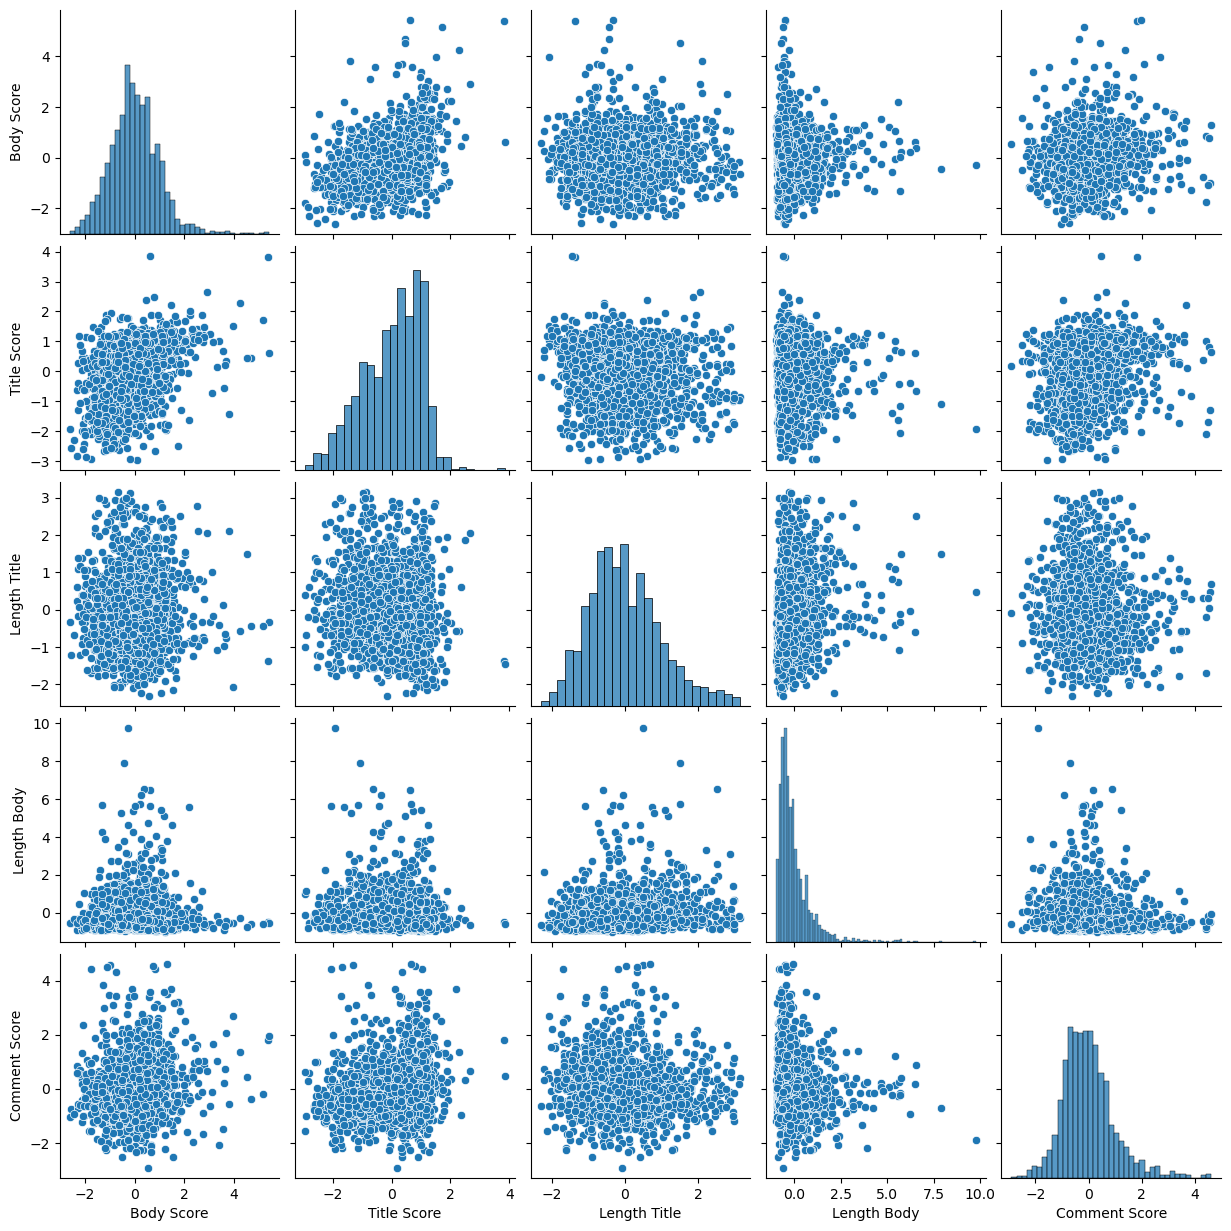

In [877]:
sns.pairplot(std_df)

Now ,let's explore the relationship between variables by calculating the coefficient correlation.

<Axes: >

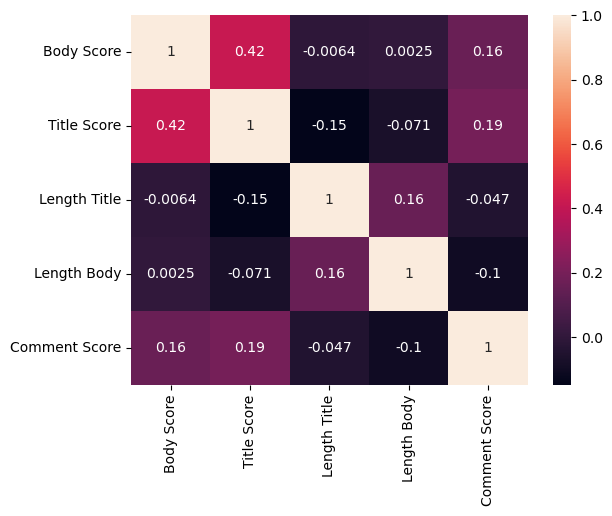

In [878]:
sns.heatmap(std_df.corr(),annot = True)

Upon initial observation, it appears that there is a correlation between the sentiment score of the title and its associated body. However, there doesn't seem to be any noticeable correlation between the other variables in the dataset.

To strengthen our assertion, We'll construct a basic linear regression model to assess the relationship between variables. Given that posts are typically created before comments are made, we'll designate all attributes of the post as predictors, with the sentiment score of the comments serving as our target variable.


In [879]:
X = std_df.drop(columns = ["Comment Score"]) # predictor variables
y = std_df[["Comment Score"]]  # target variable


X = sm.add_constant(X)

# Create a linear regression model
model = sm.OLS(y, X)

# Fit the model to the data
results = model.fit()

# print the summary of the model
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          Comment Score   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     22.63
Date:                Tue, 21 May 2024   Prob (F-statistic):           3.37e-18
Time:                        22:16:05   Log-Likelihood:                -2210.5
No. Observations:                1589   AIC:                             4431.
Df Residuals:                    1584   BIC:                             4458.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4.857e-17      0.024   1.99e-15   

From the summary of our linear regression model, we can deduce that the sentiment score of the body, the sentiment score of the title, and the length of the body of each post have a statistically significant impact on our target variable, which is the sentiment score of the comments for that post. However, it appears that the length of the header of each post does not have a statistically significant effect on our target variable ( the p-value is much larger than 5%).


We'll create a residuals plot to assess the assumptions of our linear regression model.


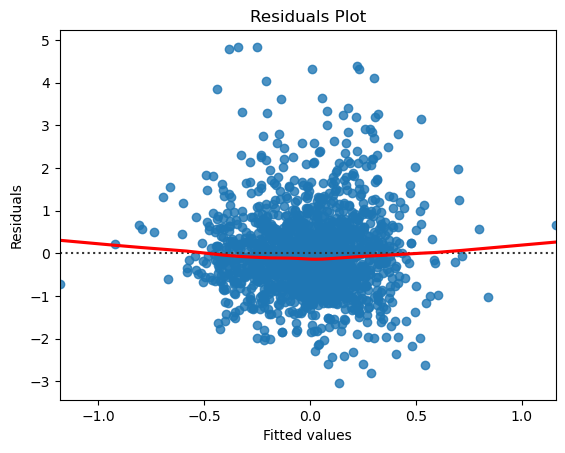

In [880]:
# Residuals Plot

residuals = results.resid

# Step 2: Plot the residuals against the predicted values
sns.residplot(x=results.fittedvalues, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

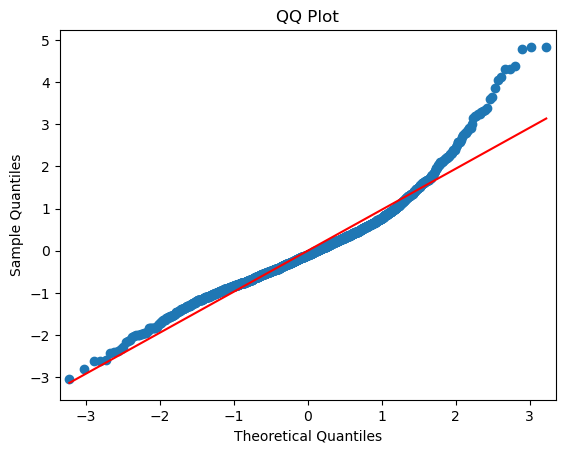

In [881]:
# QQ plot
qqplot(residuals, line='s')
plt.title('QQ Plot')
plt.show()

 As observed in our residual plot, most data points are concentrated in the center, and the curved lowess line suggests a potential non-linear relationship between our predictors and the response variable that our linear model is not capturing.
 
Regarding the QQ plot, we notice that while the data points initially align with the linear line, they increasingly diverge as they progress. This indicates that the residuals do not follow a normal distribution.

##### From our OLS summary, we see that the R-squared value is relatively low at just 5.2%, indicating low accuracy. This suggests that while the sentiment scores of the title and body, along with their associated lengths, do have some relationship with the response variable, they are not strong enough to be considered robust predictors.

##### Interestingly, the more sentiments expressed in the titles, the more sentiments will be reflected in the bodies of the posts.

#### Regular expressions represent a cornerstone in text data processing, offering versatile capabilities for extracting and manipulating information from raw text. With regular expressions, we can delve into the intricacies of unstructured data, pinpointing specific patterns or phrases that hold significance within a vast sea of text. For instance, in our case , in sentiment analysis, where understanding the emotional tone of text is paramount, regular expressions enable us to identify sentiment-bearing words or expressions, thus laying the groundwork for insightful analysis. Moreover, in tasks like named entity recognition or information extraction, regular expressions serve as invaluable tools for identifying and extracting entities such as locations, names, dates, or numerical data, contributing to the creation of structured datasets from unstructured text sources.

#### Furthermore, regular expressions play a crucial role in data preprocessing, particularly in the realm of natural language processing (NLP). By employing regular expressions, we can effectively clean text data by removing noise such as stop words, punctuation, or special characters that might obscure the underlying signal. This data cleaning process is essential for enhancing the quality and reliability of subsequent analyses, ensuring that our models are trained on clean, relevant data. Additionally, regular expressions facilitate the standardization of text data by enforcing consistent formatting conventions, thereby streamlining downstream tasks such as text classification, clustering, or information retrieval. In essence, the power of regular expressions lies not only in their ability to extract valuable insights from text but also in their capacity to transform raw text into structured, actionable data that fuels advanced analytics and decision-making processes.

#### In summary, while regular expressions provide powerful tools for analyzing text data, their use raises important considerations regarding data privacy and ethics. These concerns include the inadvertent disclosure of sensitive information during sentiment analysis or named entity recognition, the potential bias introduced by indiscriminate data cleaning, the homogenization of diverse voices through standardization, and the risk of reidentification from structured datasets. To address these issues, practitioners must prioritize ethical principles such as data minimization, anonymization, and transparency to ensure responsible and ethical data analysis practices.
